# Chargement des données Perception depuis MySQL

Cette première cellule initialise l’environnement d’analyse, importe les librairies statistiques, établit une connexion à la base MySQL, puis charge l’ensemble de la table **Perception**, correspondant aux données de l’expérience de perception (Exp1).

## Connexion MySQL
La fonction `get_py_db_connection()` (définie dans `db_utils.py`) permet d'établir une connexion locale via PyMySQL.  
La requête SQL :

```sql
SELECT * FROM Perception;
````

importe toutes les observations de l’expérience.

## Préparation des données

Plusieurs transformations sont appliquées :

* Conversion des vitesses en m/s (`velocity_ms`)
* Calcul du **temps réel** avant collision (`real_time = distance / vitesse`)
* Calcul du **temps perçu** par les participants (`perceived_time`)
* Regroupement des vitesses en trois catégories :
  **low** (20–30 km/h), **medium** (40–50 km/h), **high** (60–70 km/h)

Enfin, la cellule vérifie :

* les catégories de vitesse présentes
* les conditions météorologiques
* les distances de disparition (stimulus)

Ces impressions servent à confirmer que les données sont complètes avant l’analyse statistique.

````

In [1]:
# Obtenir une connexion et un curseur
from db_utils import get_py_db_connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, kruskal, f_oneway, pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": True,        # Nécessite LaTeX installé localement
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,          # haute résolution
    "savefig.dpi": 300,
    "figure.autolayout": True   # marge automatique
})



conn, cursor = get_py_db_connection()

query = "SELECT * FROM Perception;"
cursor.execute(query)

columns = [col[0] for col in cursor.description]

df = pd.DataFrame(cursor.fetchall(), columns=columns)
df = df.dropna()
# Regrouper les vitesses en catégories
velocity_groups = {
    'low': [20.0, 30.0],
    'medium': [40.0, 50.0],
    'high': [60.0, 70.0]
}

def categorize_velocity(velocity):
    for group, values in velocity_groups.items():
        if velocity in values:
            return group
    return 'unknown'

df['velocity_ms'] = df['velocity_id'] * (5 / 18)
df['real_time'] = df['distance_id'] / df['velocity_ms']
df['perceived_time'] = df['perceived_distance'] / df['velocity_ms']
df['velocity_group'] = df['velocity_id'].apply(categorize_velocity)


# Supposons df ta dataframe, colonne 'velocity_ms' en float
df['velocity_cat'] = df['velocity_id'].astype(int).astype(str) + " km/h"
# Vérifier catégories
print("Catégories vitesse : ", df['velocity_cat'].unique())
print("Catégories météo : ", df['weather_id'].unique())
print("Catégories distance : ", df['distance_id'].unique())

Catégories vitesse :  ['20 km/h' '60 km/h' '40 km/h' '50 km/h' '70 km/h' '30 km/h']
Catégories météo :  ['night' 'rain' 'clear']
Catégories distance :  [50. 70. 30. 60. 40. 20.]


# Calcul des erreurs de TTC (Time-To-Collision) et statistiques descriptives

À partir du temps réel avant collision (`real_time`) et du temps perçu par les participants (`perceived_time`), cette cellule calcule :

- **l’erreur d’estimation du TTC**  
  \[
  \text{error\_ttc} = \text{perceived\_time} - \text{real\_time}
  \]

Une erreur positive signifie que le participant **surestime** le temps avant impact,  
une erreur négative signifie une **sous-estimation** (cas le plus dangereux).

## Statistiques descriptives calculées

- **describe()** : min, quartiles, moyenne, écart-type, max  
- **médiane**  
- **MAE (Mean Absolute Error)** : magnitude moyenne de l’erreur  
- **Biais** (erreur signée) : tendance à surestimer / sous-estimer  
  - biais > 0 → surestimation systématique  
  - biais < 0 → sous-estimation systématique  

Ces métriques constituent la base de l’analyse comportementale des participants.


In [2]:
# Calculate TTC error
df['error_ttc'] = df['perceived_time'] - df['real_time']

# Descriptive statistics of TTC error
desc = df['error_ttc'].describe()
print("Descriptive statistics of TTC error:")
print(desc)
print(f"Median: {df['error_ttc'].median():.3f}")

# Calculate MAE and bias
mae = df['error_ttc'].abs().mean()
bias = df['error_ttc'].mean()
print(f"MAE: {mae:.3f}")
print(f"Bias (mean signed error): {bias:.3f}")


Descriptive statistics of TTC error:
count    510.000000
mean      -0.838757
std        1.765294
min       -9.660600
25%       -1.513073
50%       -0.563624
75%        0.179177
max        5.306160
Name: error_ttc, dtype: float64
Median: -0.564
MAE: 1.357
Bias (mean signed error): -0.839


# Distribution des erreurs TTC : histogramme et boxplot

Cette cellule explore visuellement la distribution des erreurs d’estimation du TTC (`error_ttc`).

Deux visualisations complémentaires sont produites :

### 1. Histogramme + courbe KDE
- Montre la **répartition globale** des erreurs.  
- La courbe KDE (Kernel Density Estimation) aide à visualiser la forme de la distribution  
  (symétrie, biais, présence de queues longues…).

### 2. Boxplot
- Met en évidence :
  - la **médiane**
  - l’**étendue interquartile** 
  - les **outliers extrêmes**
  
Ces graphiques permettent de vérifier :
- si les erreurs sont centrées autour de 0,
- si les participants ont tendance à surestimer ou sous-estimer le TTC,
- si la distribution est symétrique ou fortement biaisée.

Ils servent aussi à évaluer si les tests paramétriques (ANOVA) sont appropriés ou si des tests non paramétriques seront nécessaires.


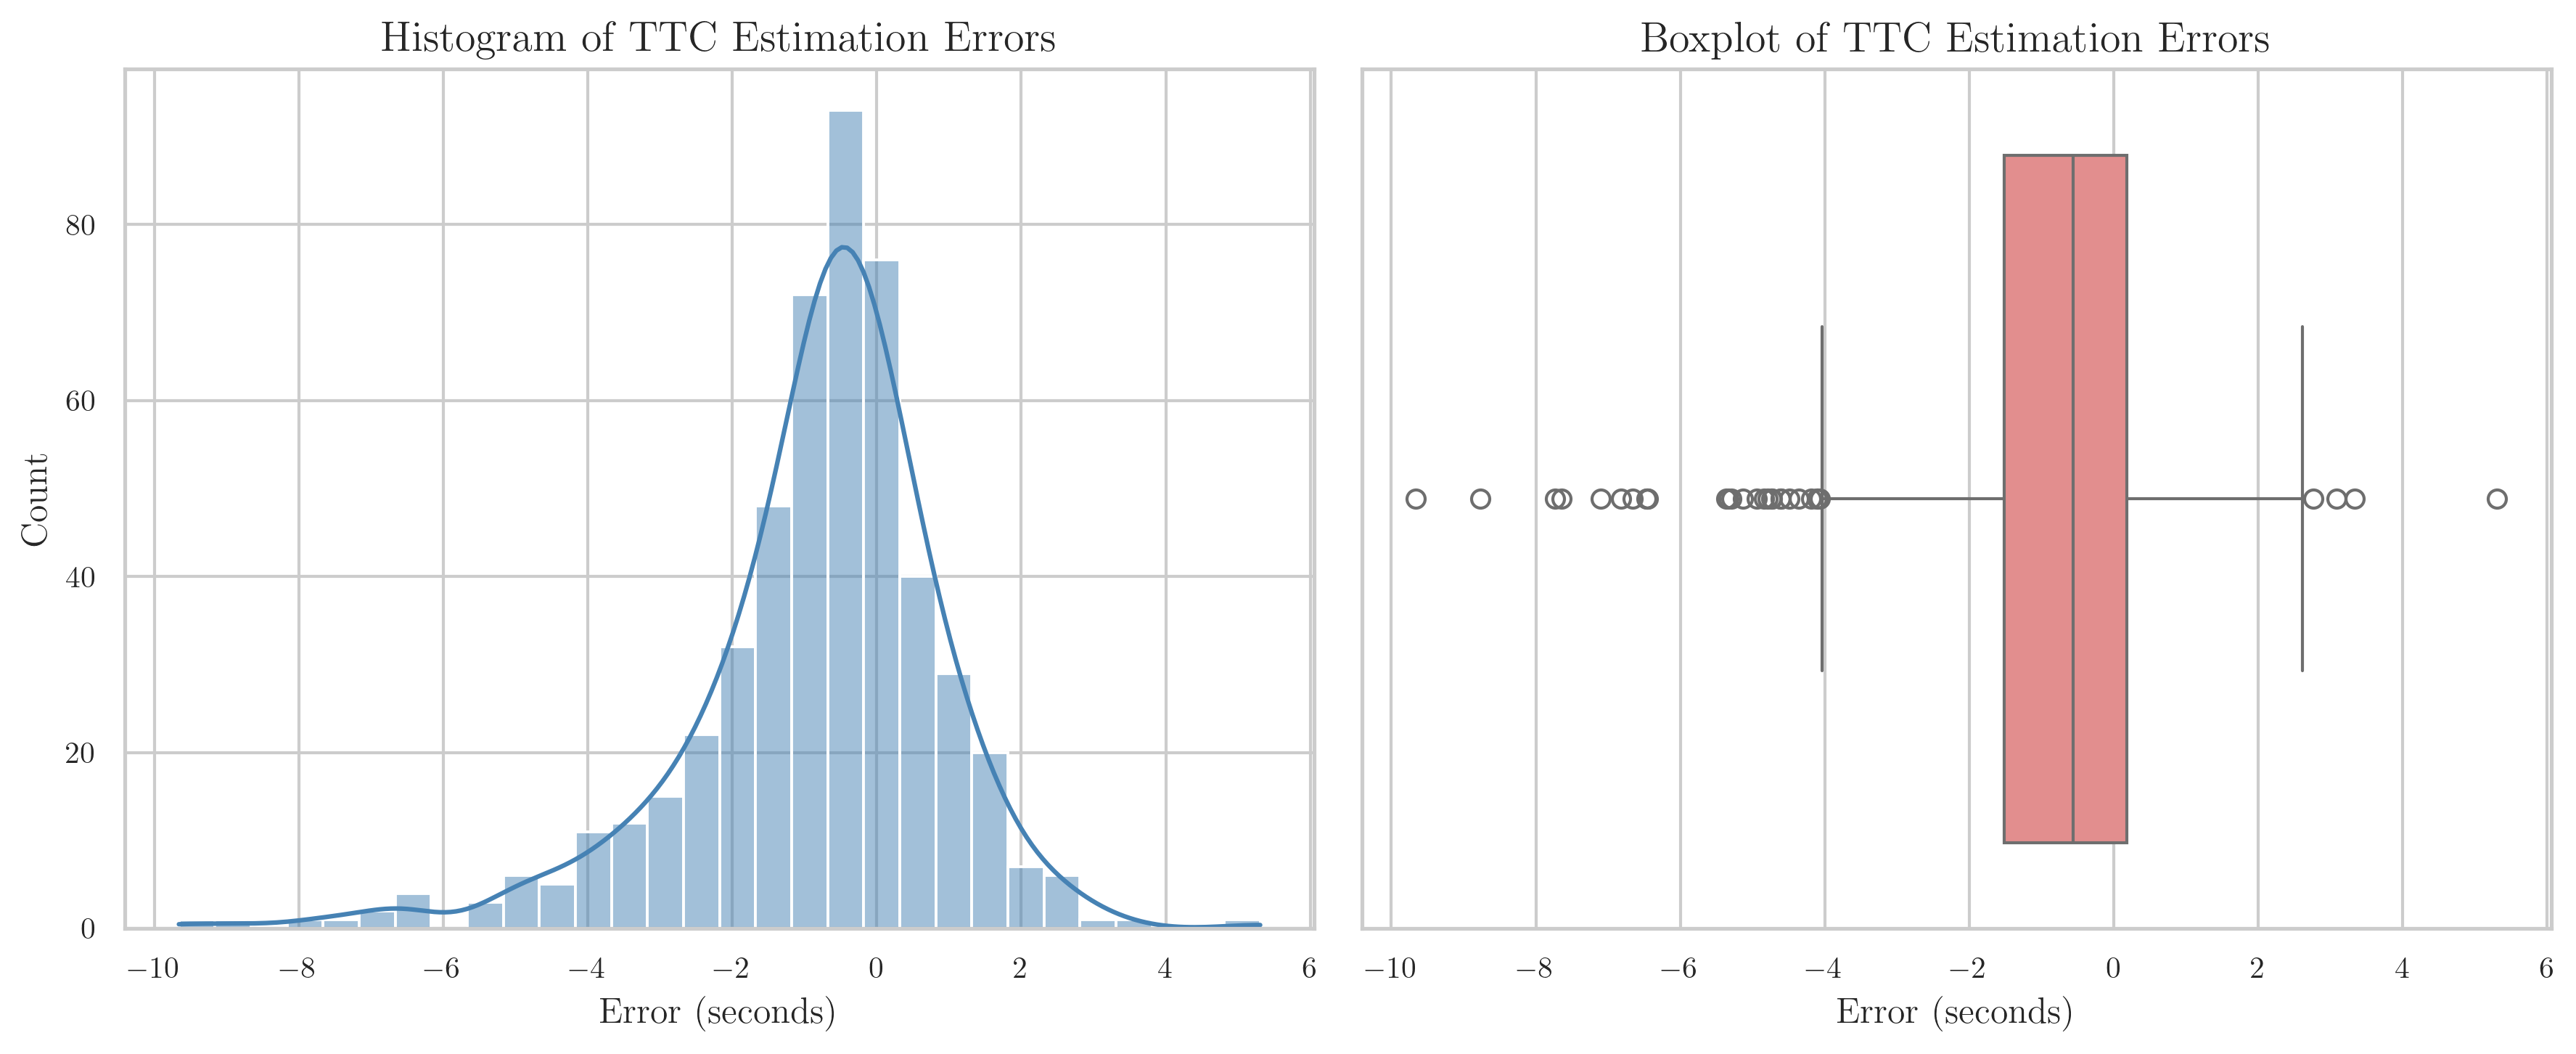

In [3]:
# Histogramme erreur TTC
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['error_ttc'], bins=30, kde=True, color='steelblue')
plt.title('Histogram of TTC Estimation Errors')
plt.xlabel('Error (seconds)')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(x=df['error_ttc'], color='lightcoral')
plt.title('Boxplot of TTC Estimation Errors')
plt.xlabel('Error (seconds)')

plt.tight_layout()
plt.show()

# Analyse de l’erreur TTC en fonction du TTC réel (par tranches)

Cette cellule examine comment l’erreur d’estimation du TTC varie en fonction du **vrai temps avant collision**.  
L’objectif est de déterminer si les participants sont plus précis lorsque le TTC est court ou long.

## Étapes réalisées

### 1.  Discrétisation du TTC réel
Le TTC réel (`real_time`) est découpé en intervalles réguliers (bins de 1 seconde).  
Cela permet de comparer l’erreur moyenne dans des tranches homogènes.

### 2.  Calcul du MAE par tranche
Pour chaque intervalle, on calcule le :
- **MAE (Mean Absolute Error)** = précision moyenne des estimations

Cela donne une courbe montrant comment la précision varie avec le TTC.

### 3.  Test statistique Kruskal-Wallis
Un test non paramétrique est appliqué pour vérifier si les erreurs diffèrent significativement entre les tranches :

- adapté car les distributions ne sont généralement **pas normales**
- équivalent non paramétrique d’un ANOVA à groupes multiples

Résultat :
- **p < 0.05** → les erreurs diffèrent selon le TTC réel  
- **p ≥ 0.05** → pas de différence significative

### 4.  Visualisation
Un graphique en barres montre le MAE dans chaque tranche de TTC réel.

Cette étape est essentielle pour comprendre :
- si les participants sont plus précis lorsque la voiture est loin ou proche
- si l’erreur augmente mécaniquement avec le TTC (effet de la tâche)


C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\4016916733.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_by_bin = df.groupby('real_time_bin')['error_ttc'].apply(lambda x: np.mean(np.abs(x)))
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\4016916733.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['error_ttc'].values for name, group in df.groupby('real_time_bin')]
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\4016916733.py:18: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requiremen

real_time_bin
(0.0, 1.0]           NaN
(1.0, 2.0]      0.515867
(2.0, 3.0]      0.752608
(3.0, 4.0]      1.035057
(4.0, 5.0]      1.291408
(5.0, 6.0]      1.788792
(6.0, 7.0]      2.066948
(7.0, 8.0]      1.812964
(8.0, 9.0]      3.226017
(9.0, 10.0]          NaN
(10.0, 11.0]    2.883481
(11.0, 12.0]         NaN
(12.0, 13.0]    5.725153
Name: error_ttc, dtype: float64
Kruskal-Wallis test: stat=nan, p=nan


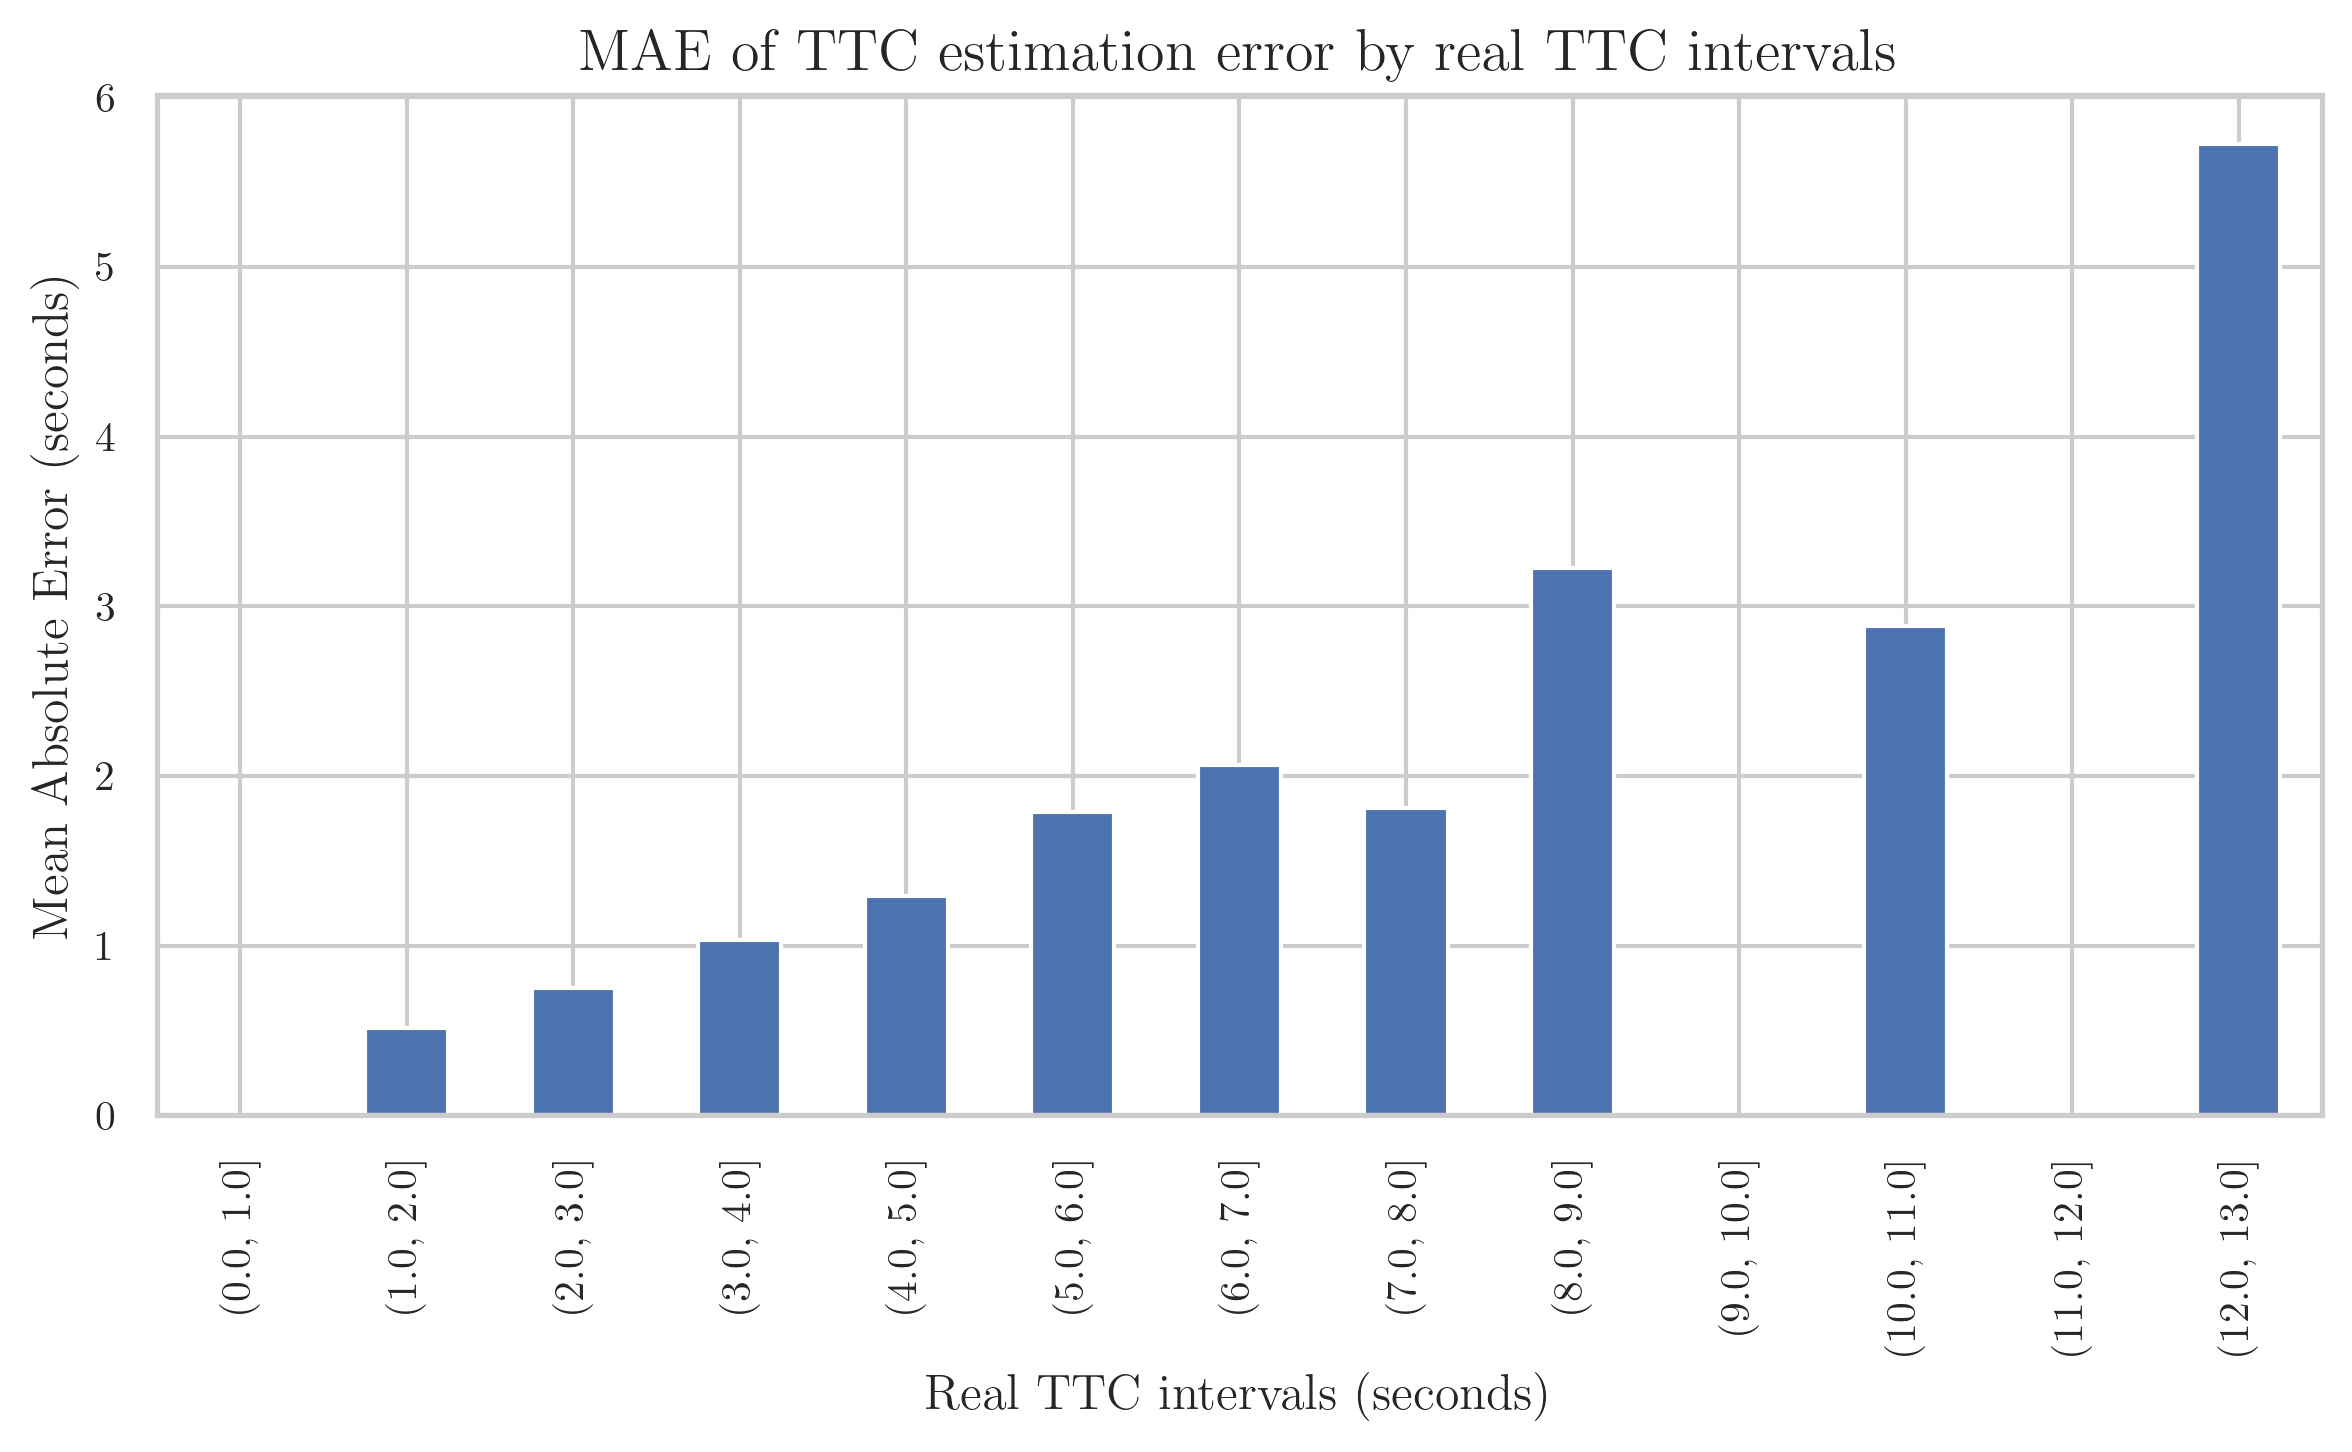

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# 1. Créer des tranches sur real_time
bins = np.arange(0, df['real_time'].max() + 1, 1)  # tranches de 2 secondes
df['real_time_bin'] = pd.cut(df['real_time'], bins=bins)

# 2. Calculer MAE par tranche
mae_by_bin = df.groupby('real_time_bin')['error_ttc'].apply(lambda x: np.mean(np.abs(x)))

print(mae_by_bin)

# 3. Statistique : Kruskal-Wallis test entre les groupes
groups = [group['error_ttc'].values for name, group in df.groupby('real_time_bin')]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis test: stat={stat:.3f}, p={p:.3e}")

# 4. Visualisation MAE par tranche
plt.figure(figsize=(8,5))
mae_by_bin.plot(kind='bar')
plt.ylabel('Mean Absolute Error (seconds)')
plt.xlabel('Real TTC intervals (seconds)')
plt.title('MAE of TTC estimation error by real TTC intervals')
plt.show()


##  Analyse ciblée : comparaison des erreurs TTC entre 3 grandes catégories de TTC réel

Après l’analyse par tranches fines (1 seconde), cette cellule réalise une analyse plus robuste en regroupant les observations en **trois intervalles larges** :

- **0–5 secondes**
- **5–10 secondes**
- **10–15 secondes**

Cette approche permet d’augmenter la taille des échantillons et d’obtenir des comparaisons plus stables statistiquement.


#### 1.  Binning en catégories larges
Les valeurs de `real_time` sont découpées en trois groupes (`pd.cut` avec labels).

#### 2.  Affichage des effectifs
Important pour vérifier que chaque groupe contient suffisamment d’observations pour un test non paramétrique.

#### 3.  Tests pairwise Mann–Whitney U  
Pour chaque paire **de groupes consécutifs** :

- `0–5s` vs `5–10s`
- `5–10s` vs `10–15s`

Mann–Whitney est utilisé car :
- les distributions d’erreur ne sont pas normales
- les groupes n’ont pas forcément la même variance

#### 4.  Correction de Bonferroni  
Pour éviter les faux positifs liés aux comparaisons multiples.

Si `reject H0 = True`, alors les groupes diffèrent significativement.




In [5]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Regroupement en 3 tranches larges
bins_coarse = [0, 5, 10, 15]
labels_coarse = ['0-5s', '5-10s', '10-15s']
df['real_time_bin_coarse'] = pd.cut(df['real_time'], bins=bins_coarse, labels=labels_coarse, right=True)

# Affichage des tailles par groupe
print("Sample sizes per coarse bin:")
print(df['real_time_bin_coarse'].value_counts())

# Tests Mann-Whitney entre groupes consécutifs
p_values = []
comparisons = []
for i in range(len(labels_coarse) - 1):
    group1 = df[df['real_time_bin_coarse'] == labels_coarse[i]]['error_ttc']
    group2 = df[df['real_time_bin_coarse'] == labels_coarse[i+1]]['error_ttc']
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    p_values.append(p)
    comparisons.append(f"{labels_coarse[i]} vs {labels_coarse[i+1]}")

# Correction de Bonferroni
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Affichage résultats
for comp, p_uncorr, p_corr, rej in zip(comparisons, p_values, pvals_corrected, reject):
    print(f"Comparison {comp}: uncorrected p = {p_uncorr:.4e}, Bonferroni corrected p = {p_corr:.4e}, reject H0? {rej}")


Sample sizes per coarse bin:
real_time_bin_coarse
0-5s      361
5-10s     119
10-15s     30
Name: count, dtype: int64
Comparison 0-5s vs 5-10s: uncorrected p = 2.1807e-12, Bonferroni corrected p = 4.3614e-12, reject H0? True
Comparison 5-10s vs 10-15s: uncorrected p = 1.7226e-06, Bonferroni corrected p = 3.4451e-06, reject H0? True


##  Relation entre erreur TTC et TTC réel : visualisation continue

Cette cellule produit un **scatterplot** montrant directement comment l’erreur d’estimation du TTC (`error_ttc`) varie en fonction du **TTC réel** (`real_time`), sans découpage en tranches.


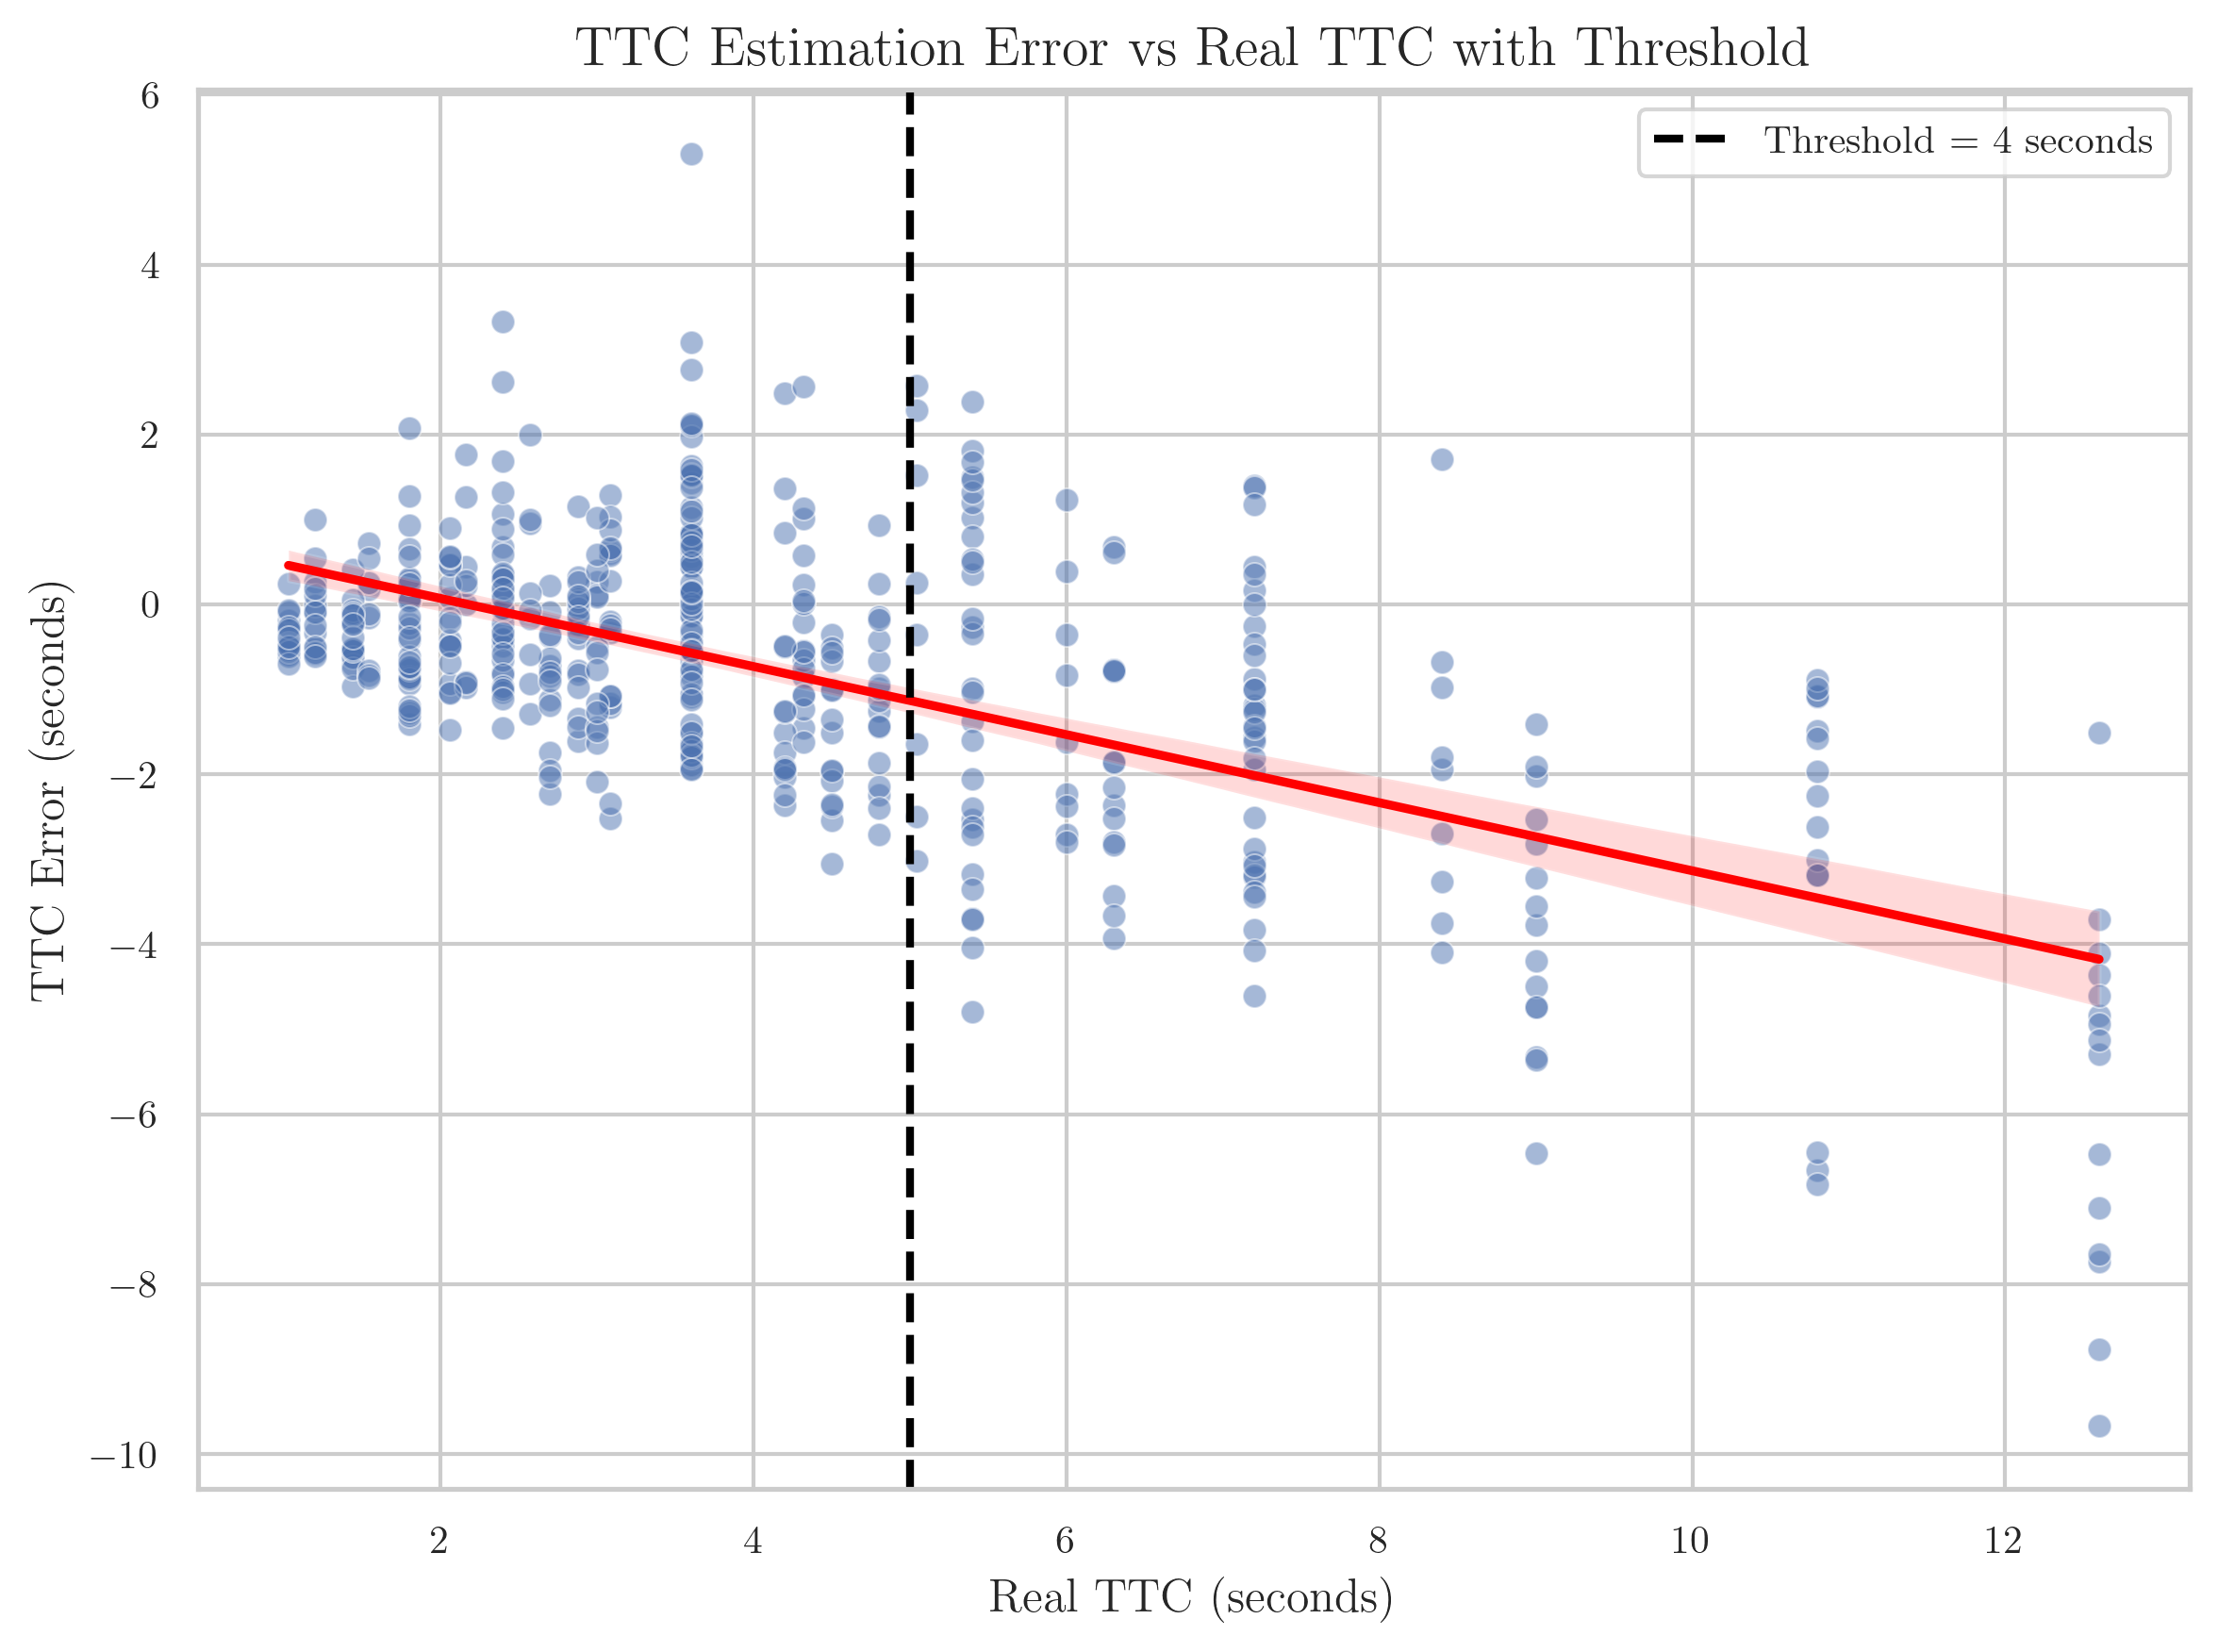

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x='real_time', y='error_ttc', data=df, alpha=0.5)
sns.regplot(x='real_time', y='error_ttc', data=df, scatter=False, color='red')
plt.axvline(x=5, color='black', linestyle='--', linewidth=2, label='Threshold = 4 seconds')
plt.title('TTC Estimation Error vs Real TTC with Threshold')
plt.xlabel('Real TTC (seconds)')
plt.ylabel('TTC Error (seconds)')
plt.legend()
plt.grid(True)
plt.show()


## Effet des facteurs expérimentaux sur l’erreur TTC : visualisations par groupes

Cette section examine comment l’erreur d’estimation du TTC varie en fonction de trois facteurs expérimentaux majeurs :

1. **La vitesse du véhicule**
2. **La condition météorologique**
3. **La distance de disparition du véhicule**

Pour chaque facteur, deux types de visualisations complémentaires sont générées :

###  1. Boxplots
Les boxplots permettent de comparer visuellement :
- la médiane,
- la dispersion,
- les asymétries,
- les outliers.

Ils donnent une première idée des différences structurelles entre les groupes.

###  2. Violin plots
Les violin plots montrent la **distribution complète** :
- densité,
- modes multiples,
- forme globale de la distribution.

Ils sont particulièrement utiles pour comprendre la variabilité inter-individuelle.

---

##  Statistiques descriptives par groupe

En complément des graphiques, des résumés statistiques sont affichés pour chaque modalité :
- **moyenne**
- **médiane**
- **écart-type**
- **effectif**

Cela permet de confirmer visuellement ce qui apparaît dans les boxplots :
- certains groupes montrent des erreurs moyennes plus importantes
- d'autres ont une variance beaucoup plus élevée
- certains facteurs semblent influencer fortement le biais perceptif

Ces résultats préparent l’analyse statistique plus formelle (ANOVA / Kruskal, post-hoc, etc.) qui suit dans le notebook.


C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\2127715583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='velocity_id', y='error_ttc', data=df, palette='Set2', ax=axs[0,0])
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\2127715583.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='velocity_id', y='error_ttc', data=df, palette='Set2', ax=axs[0,1])
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\2127715583.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weather_id', y='error_ttc', data=df, palette='Set3', a

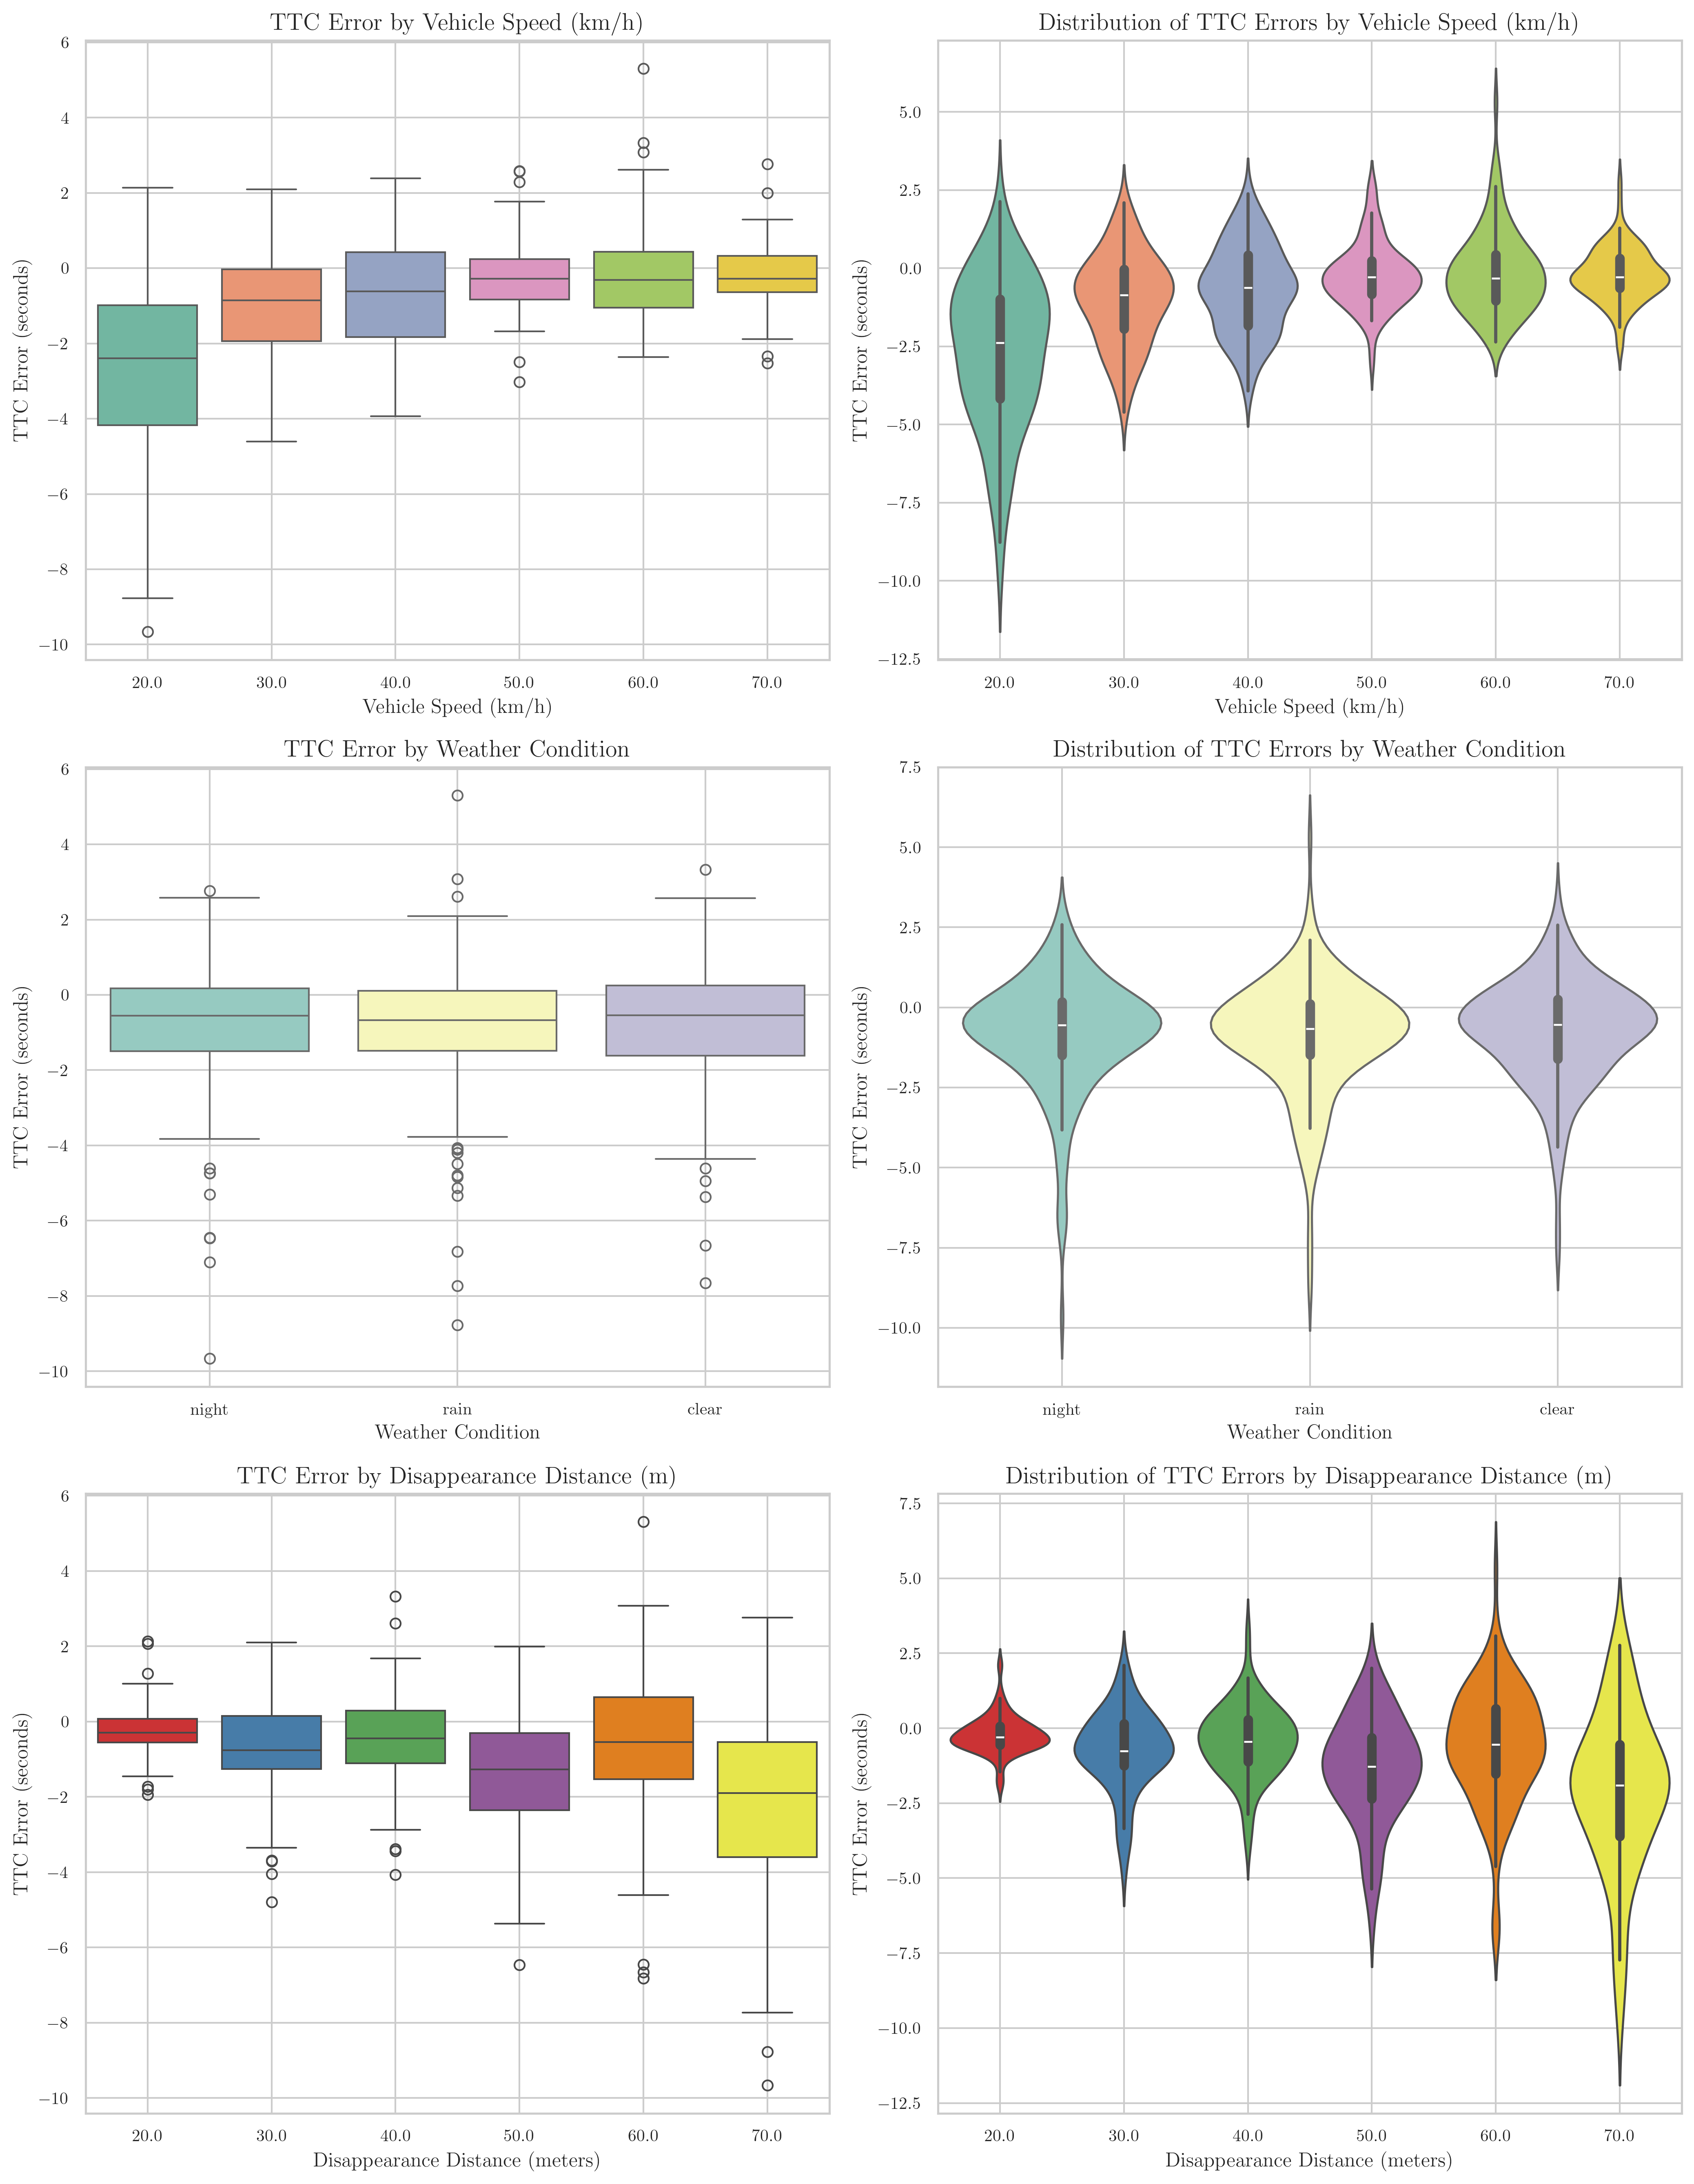

Vehicle Speed Groups:
              mean  median    std  count
velocity_id                             
20.0        -2.694  -2.391  2.420     90
30.0        -0.988  -0.858  1.453     80
40.0        -0.668  -0.620  1.397     90
50.0        -0.232  -0.286  1.034     80
60.0        -0.120  -0.317  1.336     90
70.0        -0.209  -0.277  0.867     80 

Weather Condition Groups:
             mean  median    std  count
weather_id                             
clear      -0.751  -0.545  1.642    170
night      -0.848  -0.554  1.815    171
rain       -0.918  -0.671  1.839    169 

Disappearance Distance Groups:
              mean  median    std  count
distance_id                             
20.0        -0.220  -0.296  0.640     99
30.0        -0.757  -0.759  1.338     72
40.0        -0.440  -0.441  1.215     98
50.0        -1.389  -1.275  1.762     72
60.0        -0.605  -0.548  1.976     99
70.0        -2.121  -1.903  2.628     70 



In [7]:
fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Velocity boxplot
sns.boxplot(x='velocity_id', y='error_ttc', data=df, palette='Set2', ax=axs[0,0])
axs[0,0].set_title('TTC Error by Vehicle Speed (km/h)')
axs[0,0].set_xlabel('Vehicle Speed (km/h)')
axs[0,0].set_ylabel('TTC Error (seconds)')
axs[0,0].grid(True)

# Velocity violin plot
sns.violinplot(x='velocity_id', y='error_ttc', data=df, palette='Set2', ax=axs[0,1])
axs[0,1].set_title('Distribution of TTC Errors by Vehicle Speed (km/h)')
axs[0,1].set_xlabel('Vehicle Speed (km/h)')
axs[0,1].set_ylabel('TTC Error (seconds)')
axs[0,1].grid(True)

# Weather boxplot
sns.boxplot(x='weather_id', y='error_ttc', data=df, palette='Set3', ax=axs[1,0])
axs[1,0].set_title('TTC Error by Weather Condition')
axs[1,0].set_xlabel('Weather Condition')
axs[1,0].set_ylabel('TTC Error (seconds)')
axs[1,0].grid(True)

# Weather violin plot
sns.violinplot(x='weather_id', y='error_ttc', data=df, palette='Set3', ax=axs[1,1])
axs[1,1].set_title('Distribution of TTC Errors by Weather Condition')
axs[1,1].set_xlabel('Weather Condition')
axs[1,1].set_ylabel('TTC Error (seconds)')
axs[1,1].grid(True)

# Distance boxplot
sns.boxplot(x='distance_id', y='error_ttc', data=df, palette='Set1', ax=axs[2,0])
axs[2,0].set_title('TTC Error by Disappearance Distance (m)')
axs[2,0].set_xlabel('Disappearance Distance (meters)')
axs[2,0].set_ylabel('TTC Error (seconds)')
axs[2,0].grid(True)

# Distance violin plot
sns.violinplot(x='distance_id', y='error_ttc', data=df, palette='Set1', ax=axs[2,1])
axs[2,1].set_title('Distribution of TTC Errors by Disappearance Distance (m)')
axs[2,1].set_xlabel('Disappearance Distance (meters)')
axs[2,1].set_ylabel('TTC Error (seconds)')
axs[2,1].grid(True)

plt.tight_layout()
plt.show()

# Résumés statistiques par groupe

# Vehicle speed
print("Vehicle Speed Groups:")
print(df.groupby('velocity_id')['error_ttc'].agg(['mean', 'median', 'std', 'count']).round(3), "\n")

# Weather condition
print("Weather Condition Groups:")
print(df.groupby('weather_id')['error_ttc'].agg(['mean', 'median', 'std', 'count']).round(3), "\n")

# Disappearance distance
print("Disappearance Distance Groups:")
print(df.groupby('distance_id')['error_ttc'].agg(['mean', 'median', 'std', 'count']).round(3), "\n")


#  Tests statistiques sur les facteurs catégoriels  
## (vitesse, météo, distance de disparition)

L’objectif de cette section est de déterminer si l’erreur d’estimation du TTC (`error_ttc`) diffère significativement selon :

- **la vitesse du véhicule** (`velocity_id`)
- **la condition météo** (`weather_id`)
- **la distance de disparition** (`distance_id`)

Pour analyser ces effets, cette cellule applique automatiquement :

1. **ANOVA à un facteur**   
   si les hypothèses suivantes sont respectées :
   - normalité dans chaque groupe (test de Shapiro–Wilk)
   - homogénéité des variances (test de Levene)

2. **Kruskal–Wallis**   
   lorsqu’au moins une des hypothèses de l’ANOVA est violée.  
   → test non paramétrique robuste qui compare les distributions.

###  Fonction `test_anova_or_kruskal`
La fonction réalise automatiquement :

- Extraction des groupes  
- Test de normalité  
- Test d’homogénéité  
- Choix du test approprié  
- Affichage du test utilisé + statistique + p-value

Cela permet d’avoir une procédure **automatisée et reproductible** pour tester chaque facteur expérimental.

###  Interprétation générale
- **p < 0.05** → les groupes diffèrent statistiquement  
- **p ≥ 0.05** → aucune différence détectée  



In [8]:
from scipy.stats import f_oneway, kruskal, levene, shapiro

def test_anova_or_kruskal(data, factor, dv='error_ttc'):
    groups = [data[dv][data[factor]==level] for level in data[factor].dropna().unique()]
    # Check normality in each group
    normality = [shapiro(g)[1] > 0.05 for g in groups if len(g) > 3]  # True if normal
    # Check homogeneity of variance
    _, p_levene = levene(*groups)
    if all(normality) and p_levene > 0.05:
        stat, p = f_oneway(*groups)
        test_used = 'ANOVA'
    else:
        stat, p = kruskal(*groups)
        test_used = 'Kruskal-Wallis'
    print(f"{test_used} on {factor}: stat={stat:.3f}, p={p:.4f}")
    return test_used, stat, p

# Run tests
test_anova_or_kruskal(df, 'velocity_id')
test_anova_or_kruskal(df, 'weather_id')
test_anova_or_kruskal(df, 'distance_id')


Kruskal-Wallis on velocity_id: stat=93.019, p=0.0000
Kruskal-Wallis on weather_id: stat=0.589, p=0.7450
Kruskal-Wallis on distance_id: stat=54.858, p=0.0000


('Kruskal-Wallis',
 np.float64(54.858143056072095),
 np.float64(1.396087486205602e-10))

##  Post-hoc tests : exploration des différences entre groupes

Une fois qu’un test global (ANOVA ou Kruskal–Wallis) indique qu’il existe des différences significatives entre les groupes, il est nécessaire d’identifier **quels groupes diffèrent réellement entre eux**.

Cette cellule applique automatiquement les tests post-hoc appropriés :


###  1. Si le test global utilisé est **ANOVA**
Le post-hoc appliqué est :

####  Tukey HSD (Honest Significant Difference)
- Test paramétrique standard pour comparaisons multiples.
- Contrôle l’erreur de type I.
- Identifie toutes les paires de groupes significativement différentes.


###  2. Si le test global utilisé est **Kruskal–Wallis**
Les données ne respectent pas l’ANOVA ⇒ post-hoc non paramétrique :

####  Dunn test (avec correction de Bonferroni)
- Adapté aux distributions non normales et variances hétérogènes.
- Correction stricte, garantissant des résultats robustes.


###  Fonction `posthoc_test`
Cette fonction :
1. relance le test global (ANOVA ou Kruskal selon les hypothèses),
2. sélectionne automatiquement la bonne méthode post-hoc,
3. affiche les paires de groupes significatives.

Elle est appliquée successivement pour :
- la vitesse (`velocity_id`)
- la météo (`weather_id`)
- la distance de disparition (`distance_id`)

Ce bloc permet donc de comprendre **précisément** quelles conditions expérimentales conduisent à des erreurs TTC significativement différentes.


In [9]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
def posthoc_test(data, factor, dv='error_ttc'):
    test_used, stat, p = test_anova_or_kruskal(data, factor, dv)
    if test_used == 'ANOVA' and p < 0.05:
        print(f"Post-hoc Tukey HSD for {factor}:")
        tukey = pairwise_tukeyhsd(endog=data[dv], groups=data[factor], alpha=0.05)
        print(tukey.summary())
    elif test_used == 'Kruskal-Wallis' and p < 0.05:
        print(f"Post-hoc Dunn test for {factor}:")
        dunn = sp.posthoc_dunn(data, val_col=dv, group_col=factor, p_adjust='bonferroni')
        print(dunn)
    else:
        print(f"No significant differences to test post-hoc for {factor}.")

posthoc_test(df, 'velocity_id')
posthoc_test(df, 'weather_id')
posthoc_test(df, 'distance_id')

Kruskal-Wallis on velocity_id: stat=93.019, p=0.0000
Post-hoc Dunn test for velocity_id:
              20.0      30.0          40.0          50.0          60.0  \
20.0  1.000000e+00  0.000270  1.998149e-07  1.740677e-12  1.193908e-13   
30.0  2.704177e-04  1.000000  1.000000e+00  3.491003e-02  1.741625e-02   
40.0  1.998149e-07  1.000000  1.000000e+00  8.439836e-01  5.542325e-01   
50.0  1.740677e-12  0.034910  8.439836e-01  1.000000e+00  1.000000e+00   
60.0  1.193908e-13  0.017416  5.542325e-01  1.000000e+00  1.000000e+00   
70.0  6.514359e-14  0.008212  2.952228e-01  1.000000e+00  1.000000e+00   

              70.0  
20.0  6.514359e-14  
30.0  8.211821e-03  
40.0  2.952228e-01  
50.0  1.000000e+00  
60.0  1.000000e+00  
70.0  1.000000e+00  
Kruskal-Wallis on weather_id: stat=0.589, p=0.7450
No significant differences to test post-hoc for weather_id.
Kruskal-Wallis on distance_id: stat=54.858, p=0.0000
Post-hoc Dunn test for distance_id:
              20.0      30.0      40.0      5

##  Corrélations linéaires entre l’erreur TTC et les variables continues

Afin de mieux comprendre quels facteurs influencent l’erreur d’estimation du TTC, cette section calcule les **corrélations de Pearson** entre `error_ttc` et trois variables continues :

- **`velocity_ms`** : vitesse du véhicule en m/s  
- **`distance_id`** : distance de disparition (m)  
- **`real_time`** : TTC réel (s)

La corrélation de Pearson mesure :
- la **force** du lien linéaire (|r| proche de 1 = relation forte),
- le **sens** du lien (r > 0 = erreur augmente avec la variable ; r < 0 = erreur diminue),
- la **significativité** statistique (p-value).

Chaque corrélation est calculée après filtrage des lignes contenant des valeurs manquantes.

Cette analyse permet d’identifier si les biais de perception du TTC augmentent avec :
- la vitesse réelle,
- la distance d’apparition/disparition,
- ou le TTC réel lui-même.


In [10]:
from scipy.stats import pearsonr

for var in ['velocity_ms', 'distance_id', 'real_time']:
    clean_df = df.dropna(subset=['error_ttc', var])
    r, p = pearsonr(clean_df['error_ttc'], clean_df[var])
    print(f"Pearson correlation between error_ttc and {var}: r={r:.3f}, p={p:.4f}")


Pearson correlation between error_ttc and velocity_ms: r=0.439, p=0.0000
Pearson correlation between error_ttc and distance_id: r=-0.255, p=0.0000
Pearson correlation between error_ttc and real_time: r=-0.615, p=0.0000


## Visualisation des relations linéaires entre l’erreur TTC et les variables continues

Pour compléter l’analyse par corrélation, cette section illustre les relations entre :

1. **la vitesse du véhicule (m/s)**  
2. **la distance de disparition**  
3. **le TTC réel**

et **l’erreur d’estimation du TTC**.

Chaque scatter plot montre :
- les points individuels (variabilité inter-trial),
- une **droite de régression linéaire** (tendance globale),
- la densité verticale des erreurs pour chaque valeur de la variable prédictive.

Ces graphiques permettent de :
- repérer visuellement la présence ou non d’un lien linéaire,
- détecter d’éventuels effets seuils,
- vérifier si les erreurs augmentent avec la distance ou avec le TTC réel,
- confirmer ou nuancer les résultats précédents de la corrélation de Pearson.

Les trois graphiques sont affichés côte à côte pour faciliter la comparaison.


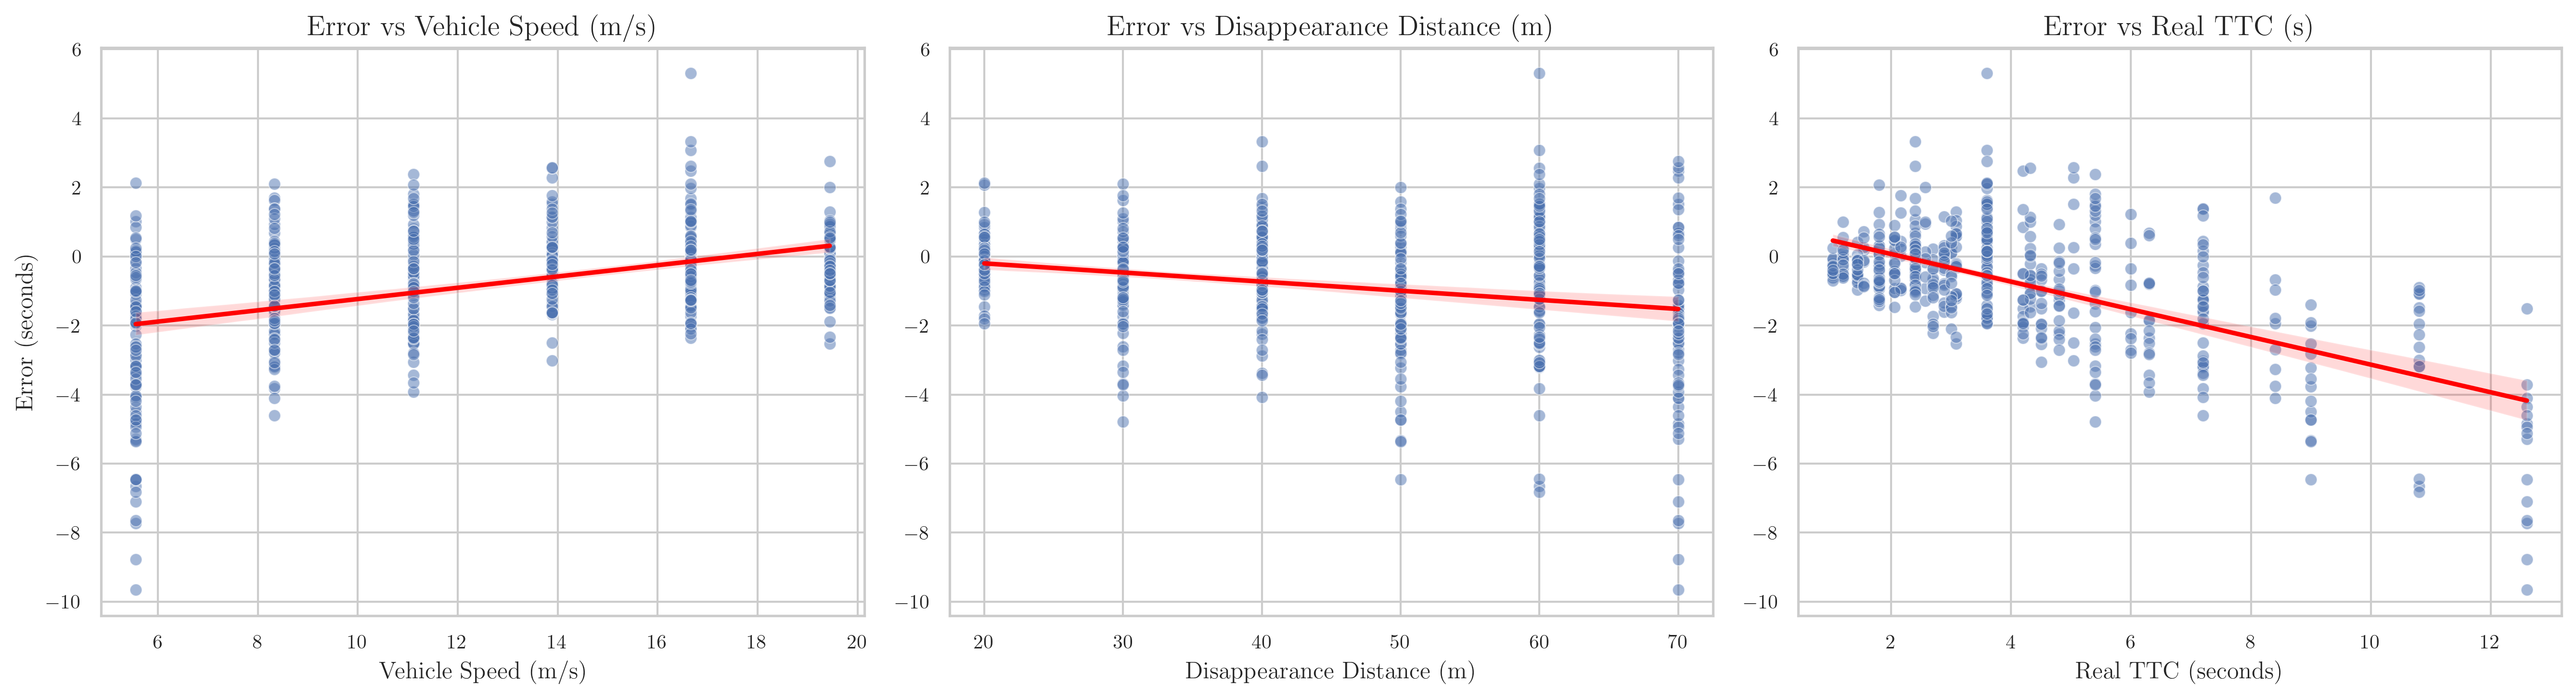

In [11]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.scatterplot(x='velocity_ms', y='error_ttc', data=df, alpha=0.5)
sns.regplot(x='velocity_ms', y='error_ttc', data=df, scatter=False, color='red')
plt.title('Error vs Vehicle Speed (m/s)')
plt.xlabel('Vehicle Speed (m/s)')
plt.ylabel('Error (seconds)')

plt.subplot(1,3,2)
sns.scatterplot(x='distance_id', y='error_ttc', data=df, alpha=0.5)
sns.regplot(x='distance_id', y='error_ttc', data=df, scatter=False, color='red')
plt.title('Error vs Disappearance Distance (m)')
plt.xlabel('Disappearance Distance (m)')
plt.ylabel('')

plt.subplot(1,3,3)
sns.scatterplot(x='real_time', y='error_ttc', data=df, alpha=0.5)
sns.regplot(x='real_time', y='error_ttc', data=df, scatter=False, color='red')
plt.title('Error vs Real TTC (s)')
plt.xlabel('Real TTC (seconds)')
plt.ylabel('')

plt.tight_layout()
plt.show()


##  Analyse des erreurs en fonction d’intervalles de TTC réel

Pour examiner comment la précision des estimations humaines varie selon le **temps-avant-collision réel (real TTC)**, nous regroupons les essais dans des intervalles réguliers de 2 secondes :

- [0–2 s)
- [2–4 s)
- [4–6 s)
- etc.

Pour chaque intervalle, nous calculons :

- **MAE (Mean Absolute Error)** : précision moyenne de l’estimation  
- **Biais (Mean Signed Error)** : tendance à surestimer (>0) ou sous-estimer (<0)

Cette analyse permet de visualiser comment la capacité d’estimation se dégrade lorsque le véhicule est loin (TTC élevé), ce qui complète les analyses précédentes (corrélation, tests non paramétriques).


In [12]:
import numpy as np

# Define bins for real_time (e.g. every 2 seconds)
bins = np.arange(0, df['real_time'].max() + 2, 2)
df['ttc_bin'] = pd.cut(df['real_time'], bins=bins, right=False)

# Calculate MAE and bias per bin
grouped = df.groupby('ttc_bin')['error_ttc']
mae_per_bin = grouped.apply(lambda x: x.abs().mean())
bias_per_bin = grouped.mean()

print("MAE per TTC bin:")
print(mae_per_bin)
print("\nBias per TTC bin:")
print(bias_per_bin)


MAE per TTC bin:
ttc_bin
[0.0, 2.0)      0.515867
[2.0, 4.0)      0.874637
[4.0, 6.0)      1.490070
[6.0, 8.0)      1.848588
[8.0, 10.0)     3.226017
[10.0, 12.0)    2.883481
[12.0, 14.0)    5.725153
Name: error_ttc, dtype: float64

Bias per TTC bin:
ttc_bin
[0.0, 2.0)     -0.271109
[2.0, 4.0)     -0.108163
[4.0, 6.0)     -0.856247
[6.0, 8.0)     -1.574488
[8.0, 10.0)    -3.083996
[10.0, 12.0)   -2.883481
[12.0, 14.0)   -5.725153
Name: error_ttc, dtype: float64


C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\2909264999.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('ttc_bin')['error_ttc']


##  MAE et biais en fonction des intervalles de TTC réel

Après avoir calculé le MAE et le biais (erreur signée) pour chaque intervalle de TTC réel,  
ce graphique permet de visualiser :

- **Comment l’erreur absolue augmente avec le TTC**  
  → Les estimations deviennent moins fiables quand le véhicule est encore loin.

- **Comment le biais évolue**  
  → Sous-estimation ou sur-estimation systématique selon le TTC.

La ligne verticale rouge marque un seuil critique de **5 secondes**, au-delà duquel l’erreur et la dispersion augmentent significativement, confirmant les analyses précédentes.


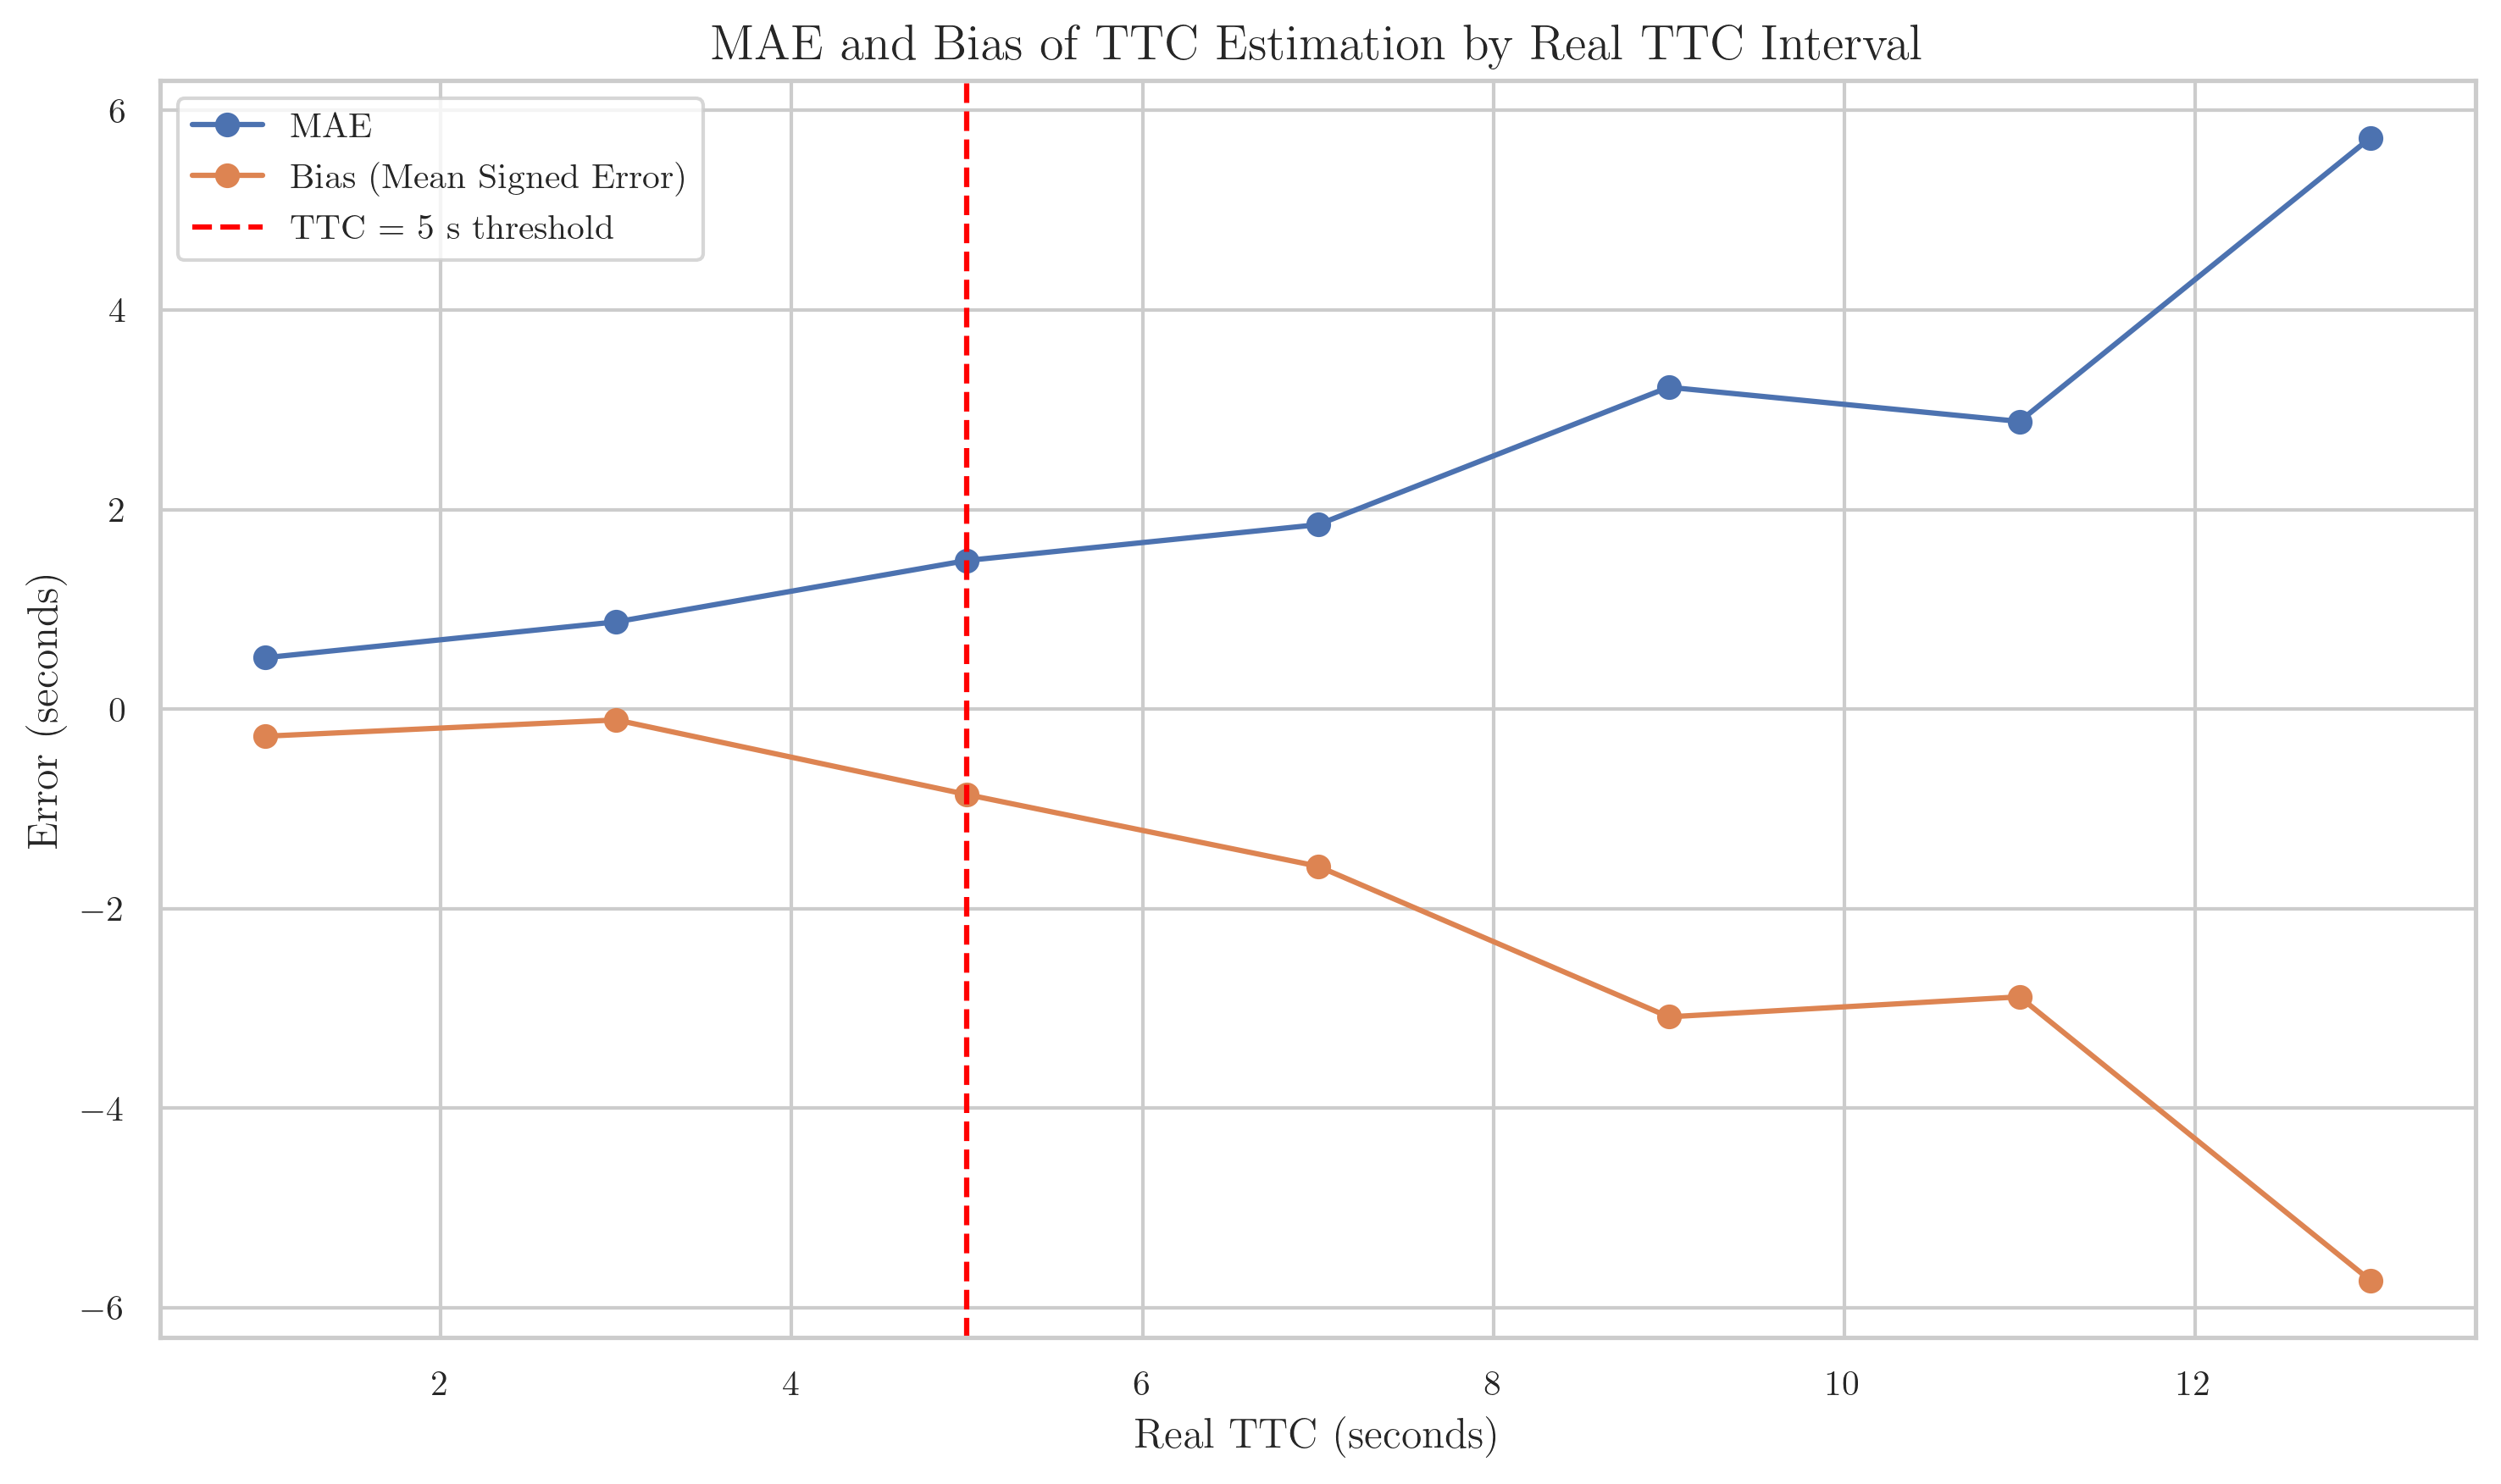

In [13]:
plt.figure(figsize=(10,6))
bin_centers = [interval.left + 1 for interval in mae_per_bin.index]

plt.plot(bin_centers, mae_per_bin, marker='o', label='MAE')
plt.plot(bin_centers, bias_per_bin, marker='o', label='Bias (Mean Signed Error)')
plt.axvline(5, color='red', linestyle='--', label='TTC = 5 s threshold')
plt.title('MAE and Bias of TTC Estimation by Real TTC Interval')
plt.xlabel('Real TTC (seconds)')
plt.ylabel('Error (seconds)')
plt.legend()
plt.grid(True)
plt.show()


##  Test statistique : variation de l’erreur selon les intervalles de TTC réel

Pour déterminer si l’erreur d’estimation du TTC change significativement selon les 
intervalles de TTC réel, on effectue un test **Kruskal–Wallis**, une alternative non
paramétrique à l’ANOVA (utilisée lorsque la normalité n’est pas garantie).

- Chaque *bin* correspond à un intervalle de TTC réel (0–2 s, 2–4 s, etc.).
- Le test compare la distribution des erreurs dans tous les bins.
- Un **p < 0.05** indiquerait que certaines plages de TTC présentent des erreurs
  significativement différentes — ce qui confirmerait que l’estimation humaine
  se dégrade progressivement avec le TTC réel.

Ce test complète les analyses précédentes basées sur le MAE et le biais.


In [14]:
# Only if you want to test if errors significantly differ between TTC bins
bins_groups = [df['error_ttc'][df['ttc_bin'] == b] for b in df['ttc_bin'].unique()]
stat, p = kruskal(*bins_groups)
print(f"Kruskal-Wallis test for error differences across TTC bins: stat={stat:.3f}, p={p:.4f}")


Kruskal-Wallis test for error differences across TTC bins: stat=151.100, p=0.0000


## Matrice de corrélation entre les variables continues

Cette section examine les relations linéaires entre :

- `error_ttc` — erreur d’estimation du TTC  
- `velocity_ms` — vitesse du véhicule (m/s)  
- `distance_id` — distance de disparition (m)  
- `real_time` — TTC réel (s)

Une **matrice de corrélation Pearson** est calculée, puis visualisée via une *heatmap* :  

- Les valeurs proches de **1** indiquent une **corrélation positive forte**  
- Les valeurs proches de **–1** indiquent une **corrélation négative forte**  
- Les valeurs proches de **0** indiquent une **absence de relation linéaire**

Cette visualisation permet de comprendre quelles variables influencent le plus l'erreur
d'estimation du TTC, et sert de base à l’interprétation des performances perceptives
des participants.


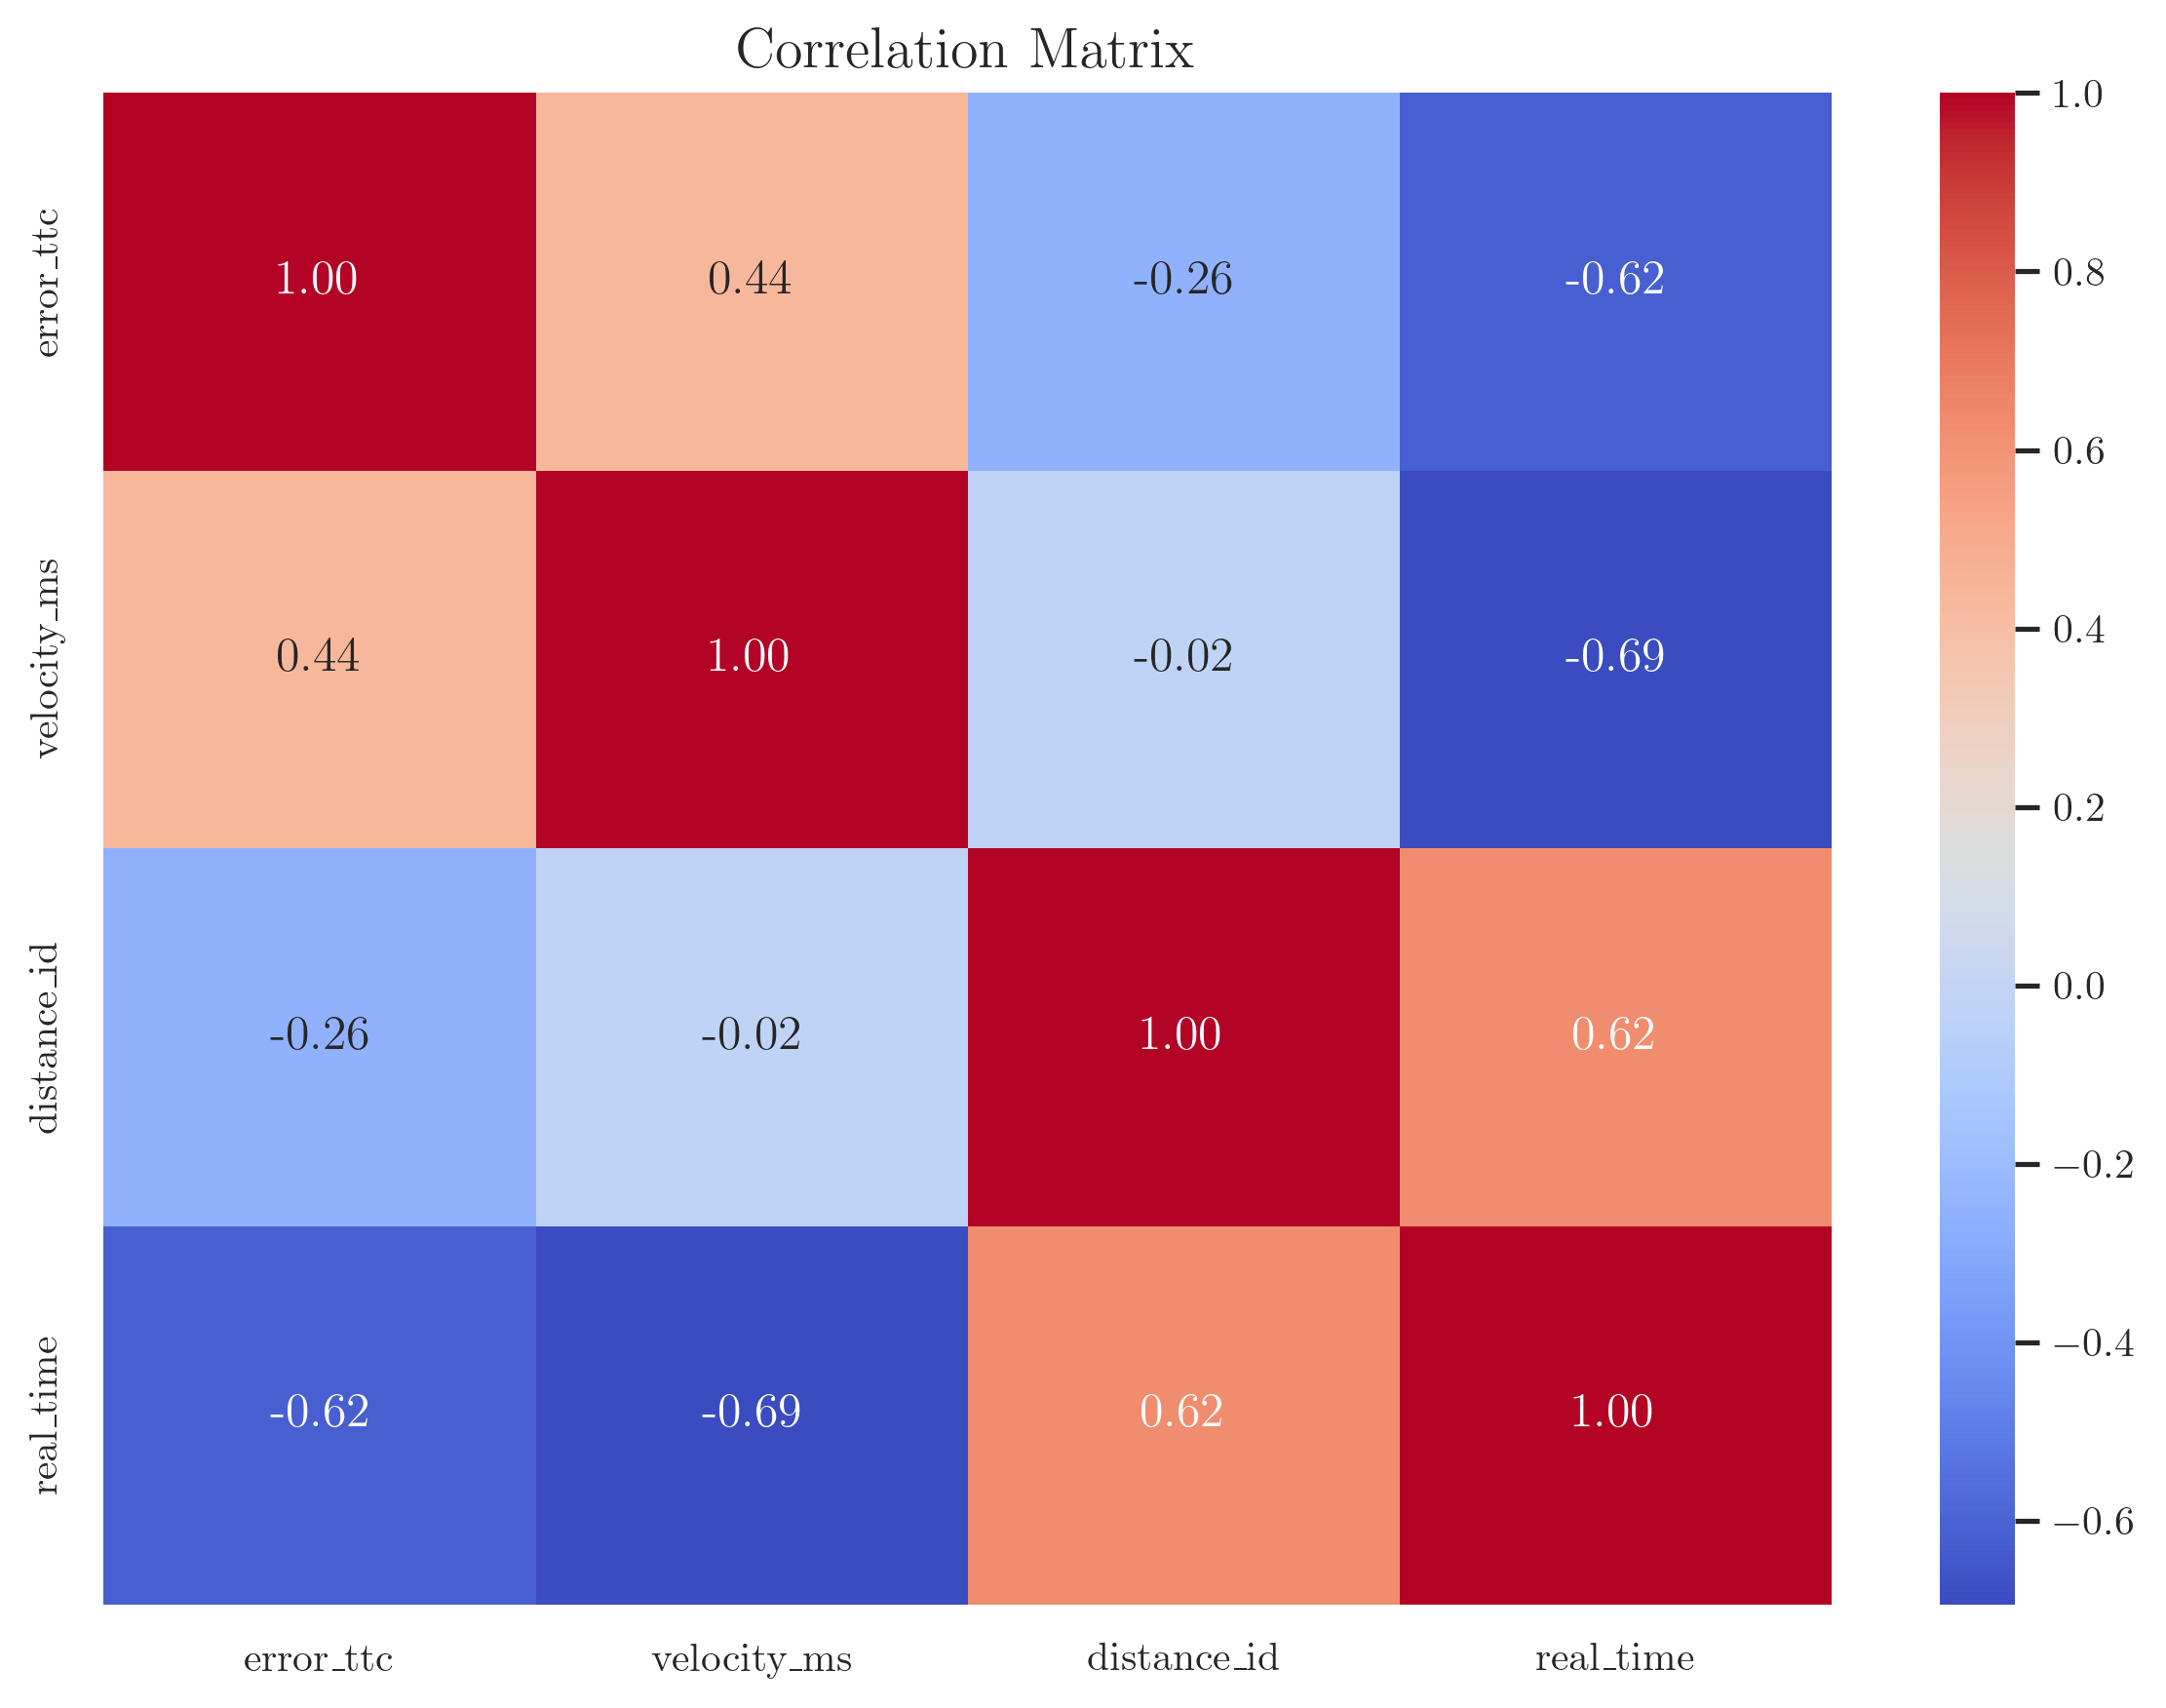

In [15]:
plt.figure(figsize=(8,6))
corr_vars = ['error_ttc', 'velocity_ms', 'distance_id', 'real_time']
corr = df[corr_vars].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


##  Effet des conditions météo sur l’erreur d’estimation du TTC

Cette section teste si l’erreur d’estimation du TTC (`error_ttc`) varie selon les
conditions météo (`weather_id`).

###  1. Tests préliminaires : normalité et homogénéité
Avant de choisir un test paramétrique ou non paramétrique, deux conditions sont évaluées :

- **Normalité des résidus par groupe météo** via le test de **Shapiro–Wilk**
- **Homogénéité des variances** entre groupes via le test de **Levene**

Ces tests déterminent si une ANOVA classique est valide ou s'il faut se tourner vers un test non paramétrique.

###  2. ANOVA à un facteur (si conditions OK)
Si :
- les groupes sont approximativement normaux, et
- les variances sont homogènes,  

→ alors on utilise une **ANOVA à un facteur** pour tester l’effet de la météo.

Si le résultat est significatif (p < 0.05), alors :
- un **post-hoc Tukey HSD** identifie quels groupes diffèrent.

###  3. Kruskal-Wallis (si ANOVA non valide)
Si l’une des conditions précédentes est violée (ce qui arrive souvent avec des données comportementales) :

→ on utilise le test **Kruskal–Wallis**, non paramétrique.

En cas de p < 0.05, on effectue :
- un **post-hoc Dunn avec correction de Bonferroni**.

Cette étape permet d’évaluer si certaines conditions météo produisent une erreur TTC
plus importante que d’autres.


In [16]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikit_posthocs as sp

# Test de normalité des résidus par condition météo
for weather in df['weather_id'].unique():
    group = df[df['weather_id'] == weather]['error_ttc']
    stat, p = stats.shapiro(group)
    print(f"Shapiro-Wilk test for Weather = {weather}: W = {stat:.3f}, p = {p:.3f}")

# Test d’homogénéité des variances
stat, p = stats.levene(
    *[df[df['weather_id'] == w]['error_ttc'] for w in df['weather_id'].unique()]
)
print(f"Levene’s test across weather groups: W = {stat:.3f}, p = {p:.3f}")

# Si normalité et homoscédasticité OK -> ANOVA
model = ols('error_ttc ~ C(weather_id)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA - Effect of Weather on TTC Error")
print(anova_table)

# Si ANOVA p < 0.05 -> post-hoc Tukey
from statsmodels.stats.multicomp import pairwise_tukeyhsd

if anova_table['PR(>F)'][0] < 0.05:
    tukey = pairwise_tukeyhsd(df['error_ttc'], df['weather_id'])
    print("\nTukey HSD post-hoc test:")
    print(tukey)

# Sinon si ANOVA non valide (normalité ou Levene NOK) -> Kruskal-Wallis
if (p < 0.05) or any(stats.shapiro(df[df['weather_id'] == w]['error_ttc'])[1] < 0.05 for w in df['weather_id'].unique()):
    print("\nKruskal-Wallis Test (non-parametric)")
    stat, p_kw = stats.kruskal(*[df[df['weather_id'] == w]['error_ttc'] for w in df['weather_id'].unique()])
    print(f"H = {stat:.3f}, p = {p_kw:.3f}")
    if p_kw < 0.05:
        print("\nDunn’s post-hoc test with Bonferroni correction:")
        print(sp.posthoc_dunn(df, val_col='error_ttc', group_col='weather_id', p_adjust='bonferroni'))


Shapiro-Wilk test for Weather = night: W = 0.898, p = 0.000
Shapiro-Wilk test for Weather = rain: W = 0.924, p = 0.000
Shapiro-Wilk test for Weather = clear: W = 0.954, p = 0.000
Levene’s test across weather groups: W = 0.167, p = 0.846

ANOVA - Effect of Weather on TTC Error
                    sum_sq     df         F   PR(>F)
C(weather_id)     2.367988    2.0  0.379013  0.68473
Residual       1583.809351  507.0       NaN      NaN

Kruskal-Wallis Test (non-parametric)
H = 0.589, p = 0.745


C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\2663020343.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


##  Effet de la distance de disparition sur l’erreur TTC

Cette section examine si l’erreur d’estimation du TTC (`error_ttc`) varie en
fonction de la distance à laquelle la voiture disparaît (`distance_id`).

###  1. Tests préliminaires
Comme précédemment, on vérifie les conditions nécessaires à une ANOVA :

- **Normalité** des distributions d’erreurs par distance (test de Shapiro–Wilk)
- **Homogénéité des variances** entre distances (test de Levene)

Ces tests déterminent si les données sont compatibles avec une ANOVA
ou s’il faut recourir à une méthode non paramétrique.

###  2. ANOVA (si hypothèses respectées)
Si :

- toutes les distances présentent une distribution normale,
- les variances sont homogènes,

→ alors on applique une **ANOVA à un facteur**.

Si l’ANOVA est significative (p < 0.05), un **post-hoc Tukey HSD** compare
les distances entre elles.

###  3. Kruskal–Wallis (si conditions invalides)
Lorsque l’une des conditions échoue (ce qui arrive souvent avec ce type de données),
on utilise le test **Kruskal–Wallis**, robuste et non paramétrique.

Si p < 0.05, on applique :

- un **post-hoc Dunn** (correction de Bonferroni),
pour identifier quelles distances se distinguent.




In [17]:
# Normality test per distance group
for dist in df['distance_id'].unique():
    group = df[df['distance_id'] == dist]['error_ttc']
    stat, p = stats.shapiro(group)
    print(f"Shapiro-Wilk test for Distance = {dist} m: W = {stat:.3f}, p = {p:.3f}")

# Levene’s test for homogeneity of variances
stat, p = stats.levene(
    *[df[df['distance_id'] == d]['error_ttc'] for d in df['distance_id'].unique()]
)
print(f"Levene’s test across distance groups: W = {stat:.3f}, p = {p:.3f}")

# ANOVA if assumptions are met
model = ols('error_ttc ~ C(distance_id)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA - Effect of Disappearance Distance on TTC Error")
print(anova_table)

if anova_table['PR(>F)'][0] < 0.05:
    print("\nTukey HSD post-hoc test for Disappearance Distance:")
    tukey = pairwise_tukeyhsd(df['error_ttc'], df['distance_id'])
    print(tukey)

# Kruskal-Wallis if assumptions violated
if (p < 0.05) or any(stats.shapiro(df[df['distance_id'] == d]['error_ttc'])[1] < 0.05 for d in df['distance_id'].unique()):
    print("\nKruskal-Wallis Test for Disappearance Distance (non-parametric)")
    stat, p_kw = stats.kruskal(*[df[df['distance_id'] == d]['error_ttc'] for d in df['distance_id'].unique()])
    print(f"H = {stat:.3f}, p = {p_kw:.3f}")
    if p_kw < 0.05:
        print("\nDunn’s post-hoc test with Bonferroni correction for Disappearance Distance:")
        print(sp.posthoc_dunn(df, val_col='error_ttc', group_col='distance_id', p_adjust='bonferroni'))


Shapiro-Wilk test for Distance = 50.0 m: W = 0.973, p = 0.127
Shapiro-Wilk test for Distance = 70.0 m: W = 0.966, p = 0.057
Shapiro-Wilk test for Distance = 30.0 m: W = 0.958, p = 0.017
Shapiro-Wilk test for Distance = 60.0 m: W = 0.961, p = 0.005
Shapiro-Wilk test for Distance = 40.0 m: W = 0.984, p = 0.298
Shapiro-Wilk test for Distance = 20.0 m: W = 0.929, p = 0.000
Levene’s test across distance groups: W = 18.560, p = 0.000

ANOVA - Effect of Disappearance Distance on TTC Error
                     sum_sq     df          F        PR(>F)
C(distance_id)   196.134811    5.0  14.222866  4.926605e-13
Residual        1390.042528  504.0        NaN           NaN

Tukey HSD post-hoc test for Disappearance Distance:


C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3698685810.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  20.0   30.0  -0.5363 0.2967 -1.2722  0.1995  False
  20.0   40.0  -0.2202 0.9386 -0.8972  0.4568  False
  20.0   50.0  -1.1686 0.0001 -1.9044 -0.4327   True
  20.0   60.0  -0.3847 0.5792 -1.0599  0.2906  False
  20.0   70.0  -1.9004    0.0 -2.6423 -1.1585   True
  30.0   40.0   0.3162 0.8238 -0.4213  1.0536  False
  30.0   50.0  -0.6323 0.2024 -1.4241  0.1596  False
  30.0   60.0   0.1517 0.9917 -0.5842  0.8875  False
  30.0   70.0  -1.3641    0.0 -2.1615 -0.5666   True
  40.0   50.0  -0.9484 0.0035 -1.6858  -0.211   True
  40.0   60.0  -0.1645 0.9825 -0.8415  0.5125  False
  40.0   70.0  -1.6802    0.0 -2.4237 -0.9367   True
  50.0   60.0   0.7839 0.0291  0.0481  1.5198   True
  50.0   70.0  -0.7318 0.0931 -1.5293  0.0656  False
  60.0   70.0  -1.5157    0.0 -2.2576 -0.7738   True
----------------------------------------------

##  Analyse des caractéristiques des participants

Afin d’examiner si certaines caractéristiques individuelles influencent l’erreur
d’estimation du TTC (`error_ttc`), on fusionne les données de perception
avec les informations démographiques des participants.

###  1. Jointure des données
On récupère la table `Participant` (âge, sexe, taille, permis, score de réalisme…)
et on l’associe à chaque essai de perception en utilisant `participant_id`.
Cela produit un tableau consolidé `df_merged`.

###  2. Construction de groupes d’âge et de taille
Pour analyser des effets éventuellement non linéaires, on discretise :

- l’âge en **4 quantiles** (`Q1–Q4`)  
- la taille en **5 quantiles** (`Q1–Q5`)

`pandas.qcut()` permet :
- d’obtenir les intervalles réels des quantiles → utile pour la description  
- d’attribuer des labels humains (`Group 1`, `Group 2`, etc.)

💡 Cela permet ensuite de comparer les erreurs TTC entre groupes homogènes
de participants.

###  3. Vérification des effectifs
On affiche la distribution des individus dans chaque catégorie pour s’assurer
que les groupes sont équilibrés — condition importante pour les tests statistiques.

Ces groupes serviront pour les analyses visuelles (boxplots, violins) et tests
statistiques postérieurs (Kruskal, Dunn, etc.).


In [18]:
conn, cursor = get_py_db_connection()

query = "SELECT * FROM Participant;"
cursor.execute(query)

columns = [col[0] for col in cursor.description]

df_part = pd.DataFrame(cursor.fetchall(), columns=columns)
df_part = df_part.dropna()
# Merge TTC data with participant characteristics
df_merged = df.merge(df_part, on='participant_id', how='left')


In [19]:
import pandas as pd

# 1. Calculer les bins sans labels pour récupérer les intervalles (cat.categories)
age_bins = pd.qcut(df_merged['age'], q=4, duplicates='drop')
height_bins = pd.qcut(df_merged['height'], q=5, duplicates='drop')

print("Age bin intervals:")
print(age_bins.cat.categories)  # Affiche les intervalles réels pour age

print("\nHeight bin intervals:")
print(height_bins.cat.categories)  # Affiche les intervalles réels pour height

# 2. Créer des colonnes catégorielles avec labels (optionnel)
age_labels = ['Group 1','Group 2','Group 3','Group 4']
height_labels = ['Group 1','Group 2','Group 3','Group 4','Group 5']

df_merged['age_cat'] = pd.qcut(df_merged['age'], q=4, labels=age_labels, duplicates='drop')
df_merged['height_cat'] = pd.qcut(df_merged['height'], q=5, labels=height_labels, duplicates='drop')

# 3. Afficher la distribution des catégories
print("\nDistribution of age categories:")
print(df_merged['age_cat'].value_counts().sort_index())

print("\nDistribution of height categories:")
print(df_merged['height_cat'].value_counts().sort_index())


Age bin intervals:
IntervalIndex([(20.999, 26.0], (26.0, 27.0], (27.0, 32.0], (32.0, 62.0]], dtype='interval[float64, right]')

Height bin intervals:
IntervalIndex([(156.999, 167.0],   (167.0, 171.0],   (171.0, 176.0],
                 (176.0, 180.0],   (180.0, 190.0]],
              dtype='interval[float64, right]')

Distribution of age categories:
age_cat
Group 1    188
Group 2     54
Group 3     81
Group 4    107
Name: count, dtype: int64

Distribution of height categories:
height_cat
Group 1    107
Group 2     80
Group 3     81
Group 4     81
Group 5     81
Name: count, dtype: int64


##  Visualisation des erreurs TTC selon les caractéristiques des participants

L’objectif de cette section est d’examiner si les caractéristiques individuelles
des participants — âge, taille, sexe et possession du permis de conduire — sont
associées à des différences d’erreur d’estimation du TTC (`error_ttc`).

Pour cela, on utilise deux types de visualisations complémentaires :

###  Boxplots & Violin plots
Les **boxplots** permettent :
- de comparer la médiane et la dispersion des erreurs par catégorie,
- de repérer des asymétries ou extrêmes.

Les **violin plots** montrent :
- la **densité** des valeurs,
- la forme complète de la distribution,
- des différences fines invisibles dans un boxplot seul.

###  Variables explorées
- **Age** (groupé en quartiles)
- **Height** (groupée en 5 quantiles)
- **Sex** (Man / Woman)
- **Driver License** (Oui / Non)

Chaque variable est affichée en **boxplot + violin**, permettant d'évaluer
simultanément :
- la variabilité intra-groupe,
- l’effet potentiel de la variable sur l’erreur TTC,
- l’homogénéité ou l’hétérogénéité des distributions.

###  Résumés statistiques
Pour compléter les visualisations, des statistiques descriptives sont affichées :
- moyenne
- médiane
- écart-type
- nombre d’essais par groupe



C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3422280227.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age_cat', y='error_ttc', data=df_merged, palette='Blues', ax=axs[0,0])
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3422280227.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='age_cat', y='error_ttc', data=df_merged, palette='Blues', ax=axs[0,1])
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3422280227.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='height_cat', y='error_ttc', data=df_merged, pa

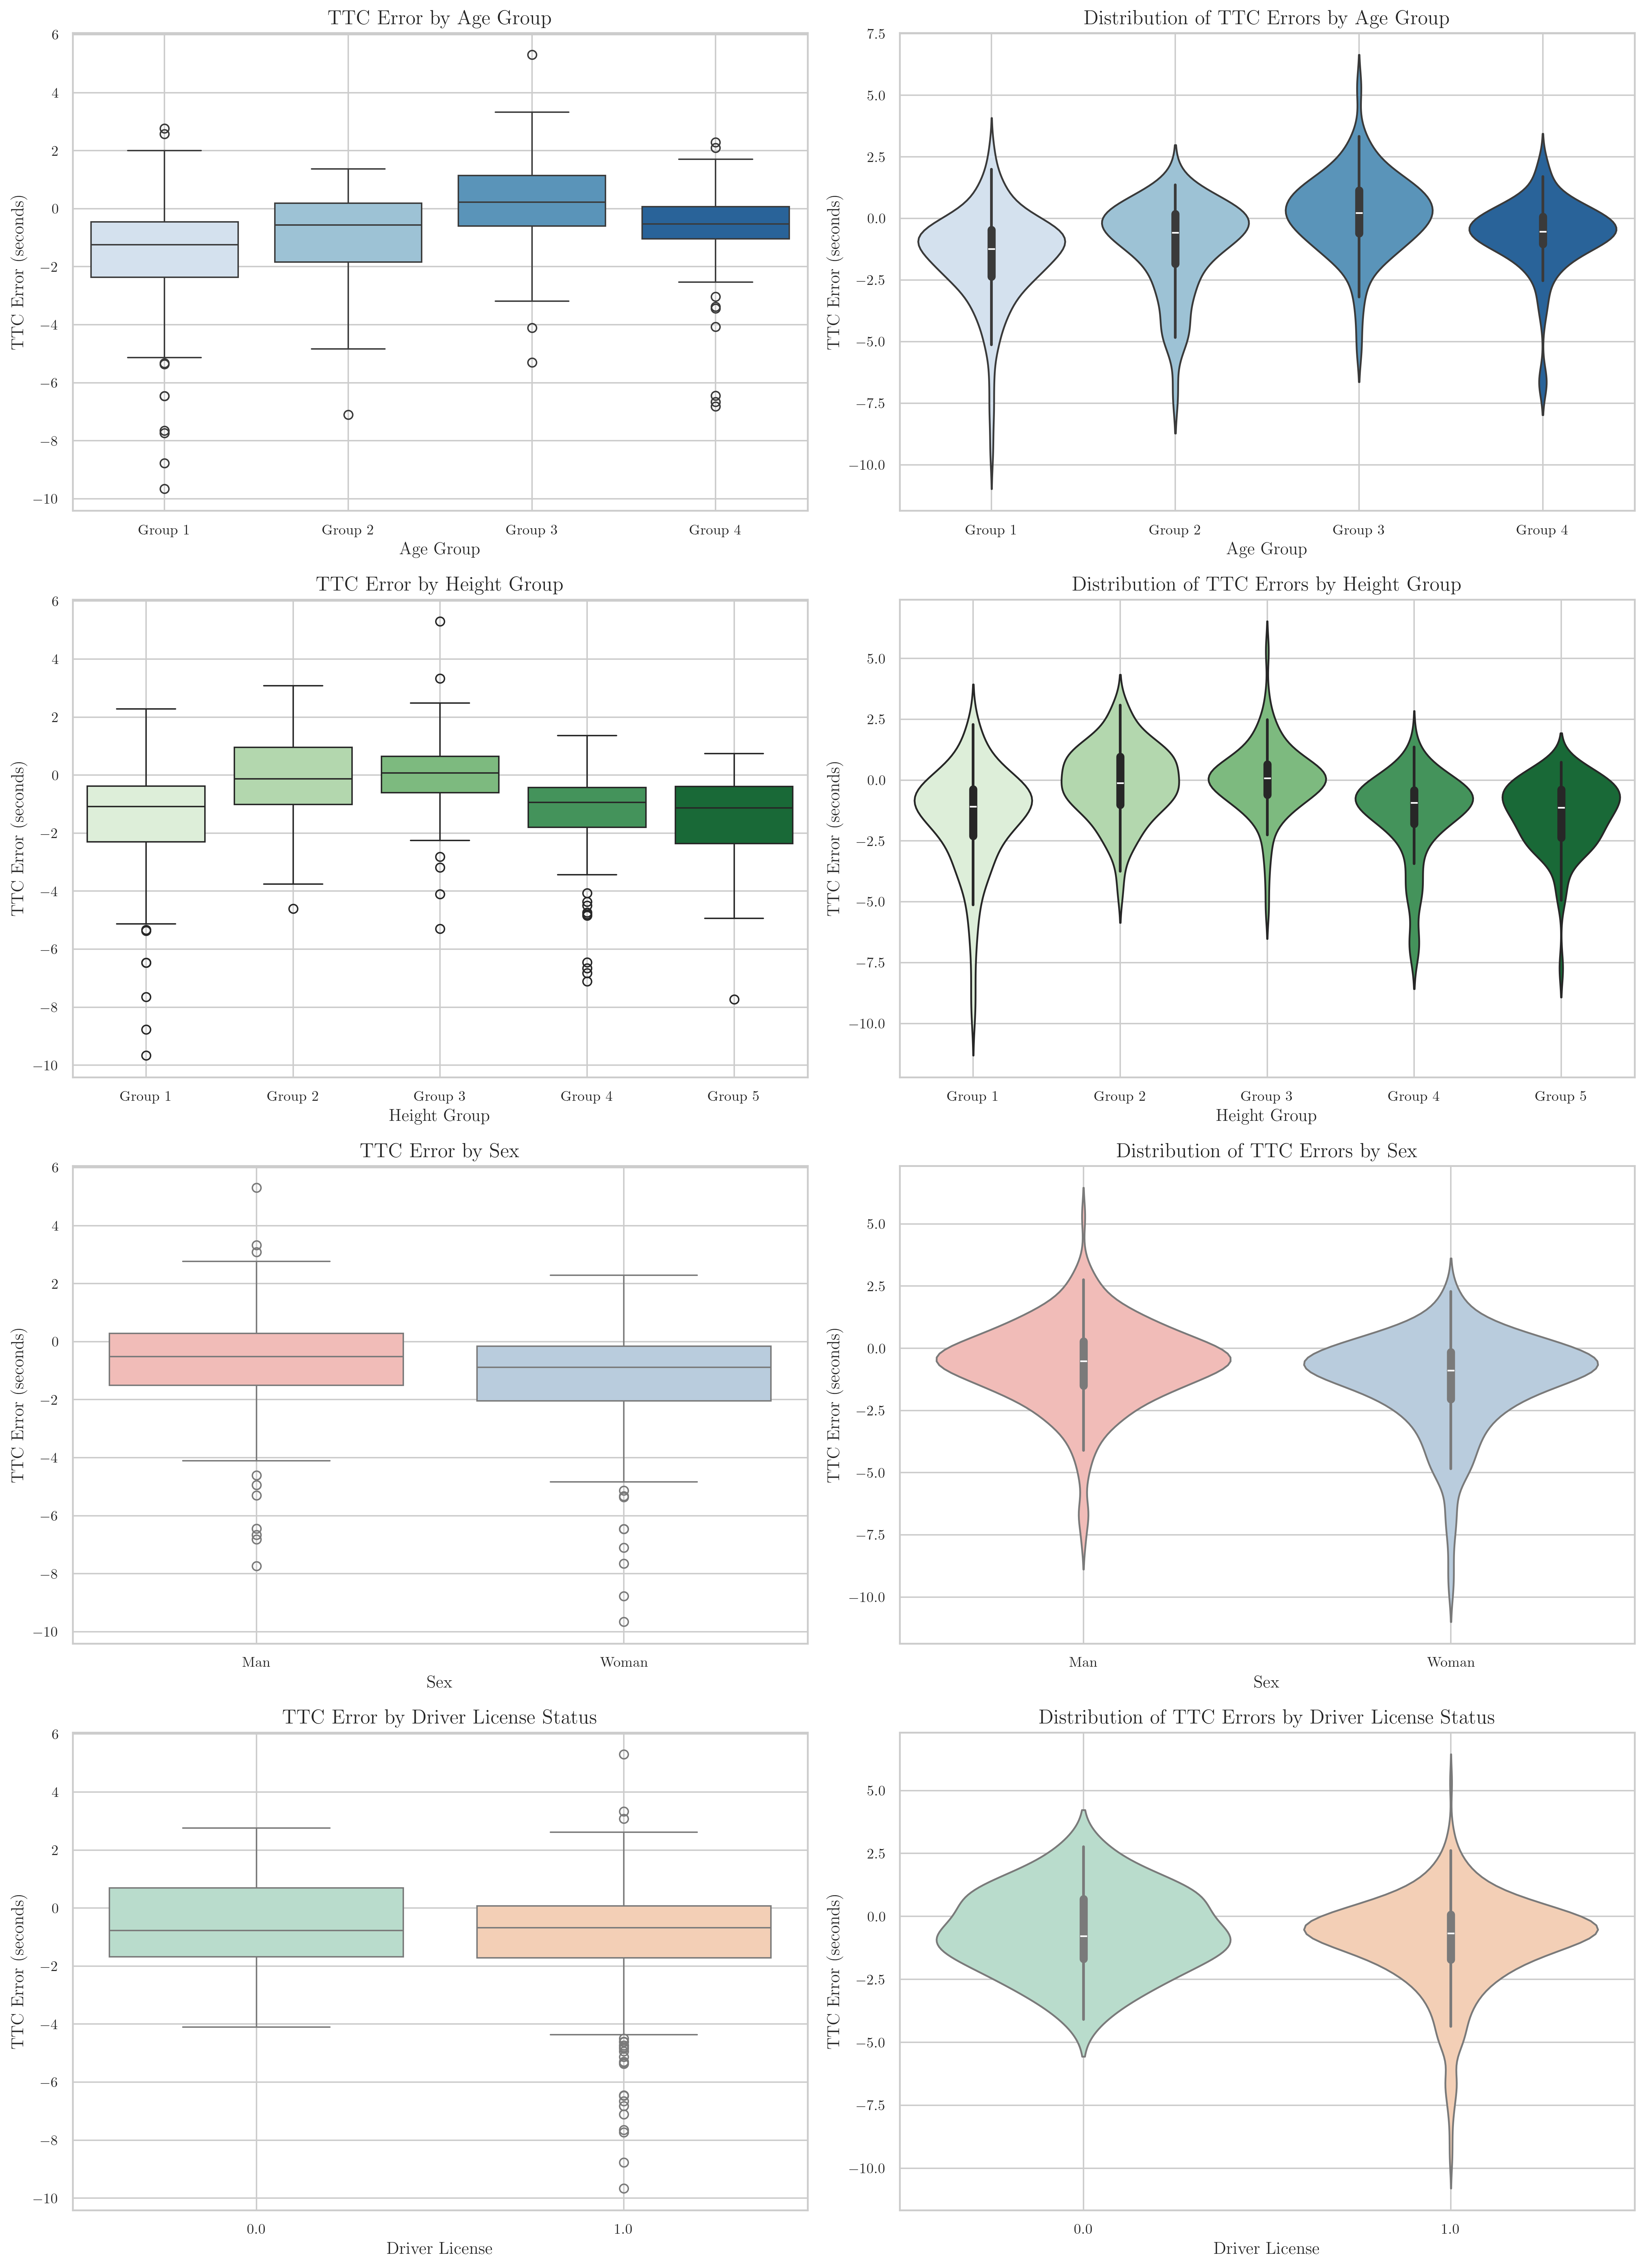

Height Groups:
         mean  median    std  count
height                             
157.0  -2.140  -1.599  1.703     27
161.0  -3.526  -2.371  2.304     27
166.0   0.095  -0.031  1.114     26
167.0  -0.631  -0.590  0.802     27
169.0  -1.310  -1.002  1.104     27
170.0   0.501   0.562  1.212     27
171.0   0.495   0.706  1.417     26
173.0   0.681   0.746  1.734     27
176.0  -0.354  -0.095  1.199     54
178.0  -1.131  -0.624  1.642     54
180.0  -2.148  -1.667  1.871     27
185.0  -1.652  -1.495  0.984     27
187.0  -0.491  -0.094  1.138     27
190.0  -2.079  -1.849  1.638     27 

Weather Condition Groups:
             mean  median    std  count
weather_id                             
clear      -0.751  -0.545  1.642    170
night      -0.848  -0.554  1.815    171
rain       -0.918  -0.671  1.839    169 

Disappearance Distance Groups:
              mean  median    std  count
distance_id                             
20.0        -0.220  -0.296  0.640     99
30.0        -0.757  -0.75

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


fig, axs = plt.subplots(4, 2, figsize=(16, 22))

# Age boxplot
sns.boxplot(x='age_cat', y='error_ttc', data=df_merged, palette='Blues', ax=axs[0,0])
axs[0,0].set_title('TTC Error by Age Group')
axs[0,0].set_xlabel('Age Group')
axs[0,0].set_ylabel('TTC Error (seconds)')
axs[0,0].grid(True)

# Age violin plot
sns.violinplot(x='age_cat', y='error_ttc', data=df_merged, palette='Blues', ax=axs[0,1])
axs[0,1].set_title('Distribution of TTC Errors by Age Group')
axs[0,1].set_xlabel('Age Group')
axs[0,1].set_ylabel('TTC Error (seconds)')
axs[0,1].grid(True)

# Height boxplot
sns.boxplot(x='height_cat', y='error_ttc', data=df_merged, palette='Greens', ax=axs[1,0])
axs[1,0].set_title('TTC Error by Height Group')
axs[1,0].set_xlabel('Height Group')
axs[1,0].set_ylabel('TTC Error (seconds)')
axs[1,0].grid(True)

# Height violin plot
sns.violinplot(x='height_cat', y='error_ttc', data=df_merged, palette='Greens', ax=axs[1,1])
axs[1,1].set_title('Distribution of TTC Errors by Height Group')
axs[1,1].set_xlabel('Height Group')
axs[1,1].set_ylabel('TTC Error (seconds)')
axs[1,1].grid(True)

# Sex boxplot
sns.boxplot(x='sex', y='error_ttc', data=df_merged, palette='Pastel1', ax=axs[2,0])
axs[2,0].set_title('TTC Error by Sex')
axs[2,0].set_xlabel('Sex')
axs[2,0].set_ylabel('TTC Error (seconds)')
axs[2,0].grid(True)

# Sex violin plot
sns.violinplot(x='sex', y='error_ttc', data=df_merged, palette='Pastel1', ax=axs[2,1])
axs[2,1].set_title('Distribution of TTC Errors by Sex')
axs[2,1].set_xlabel('Sex')
axs[2,1].set_ylabel('TTC Error (seconds)')
axs[2,1].grid(True)

# Driver license boxplot
sns.boxplot(x='driver_license', y='error_ttc', data=df_merged, palette='Pastel2', ax=axs[3,0])
axs[3,0].set_title('TTC Error by Driver License Status')
axs[3,0].set_xlabel('Driver License')
axs[3,0].set_ylabel('TTC Error (seconds)')
axs[3,0].grid(True)

# Driver license violin plot
sns.violinplot(x='driver_license', y='error_ttc', data=df_merged, palette='Pastel2', ax=axs[3,1])
axs[3,1].set_title('Distribution of TTC Errors by Driver License Status')
axs[3,1].set_xlabel('Driver License')
axs[3,1].set_ylabel('TTC Error (seconds)')
axs[3,1].grid(True)

plt.tight_layout()
plt.show()


# Vehicle speed
print("Height Groups:")
print(df_merged.groupby('height')['error_ttc'].agg(['mean', 'median', 'std', 'count']).round(3), "\n")

# Weather condition
print("Weather Condition Groups:")
print(df_merged.groupby('weather_id')['error_ttc'].agg(['mean', 'median', 'std', 'count']).round(3), "\n")

# Disappearance distance
print("Disappearance Distance Groups:")
print(df_merged.groupby('distance_id')['error_ttc'].agg(['mean', 'median', 'std', 'count']).round(3), "\n")

##  Tests statistiques : influence des variables individuelles sur l’erreur TTC

Dans cette section, nous testons si certaines caractéristiques des participants
affectent significativement leur erreur d’estimation du TTC (`error_ttc`).  
L’analyse combine :

- **statistiques descriptives par groupe**  
- **tests non paramétriques** (Mann–Whitney / Kruskal–Wallis)  
- **corrélations continues** (Pearson)

Ces analyses complètent les visualisations précédentes en permettant d’identifier
des **effets significatifs** potentiels.


###  1. Sexe (Man vs Woman)

Pour chaque sexe, on affiche :
- effectif `N`
- moyenne
- médiane
- écart-type

Un test **Mann–Whitney U** est utilisé car :
- il y a exactement 2 groupes,
- la normalité n’est pas garantie.

Objectif → tester si les hommes et les femmes diffèrent dans leur estimation du TTC.


###  2. Permis de conduire (Yes / No)

Même logique que pour le sexe :
- statistiques descriptives,
- test **Mann–Whitney** pour comparer les deux groupes.

Hypothèse intuitive : posséder un permis pourrait améliorer la perception du mouvement.


###  3. Âge (catégories quantiles)

Les groupes d’âge (`age_cat`) sont construits en 4 quantiles de taille équilibrée.

Pour ces groupes :
- statistiques descriptives,
- test **Kruskal–Wallis** (équivalent non-paramétrique d’une ANOVA).

Permet de tester si l’âge influence l’erreur TTC.


###  4. Taille (catégories quantiles)

Même approche que pour l’âge :
- 5 quantiles (`height_cat`),
- statistiques descriptives,
- test **Kruskal–Wallis**.


###  5. Corrélations continues : âge & taille

Enfin, on vérifie si les variables continues :
- `age`
- `height`

sont **corrélées linéairement** à l’erreur TTC via un **test de Pearson**.

Résultats utiles pour :
- détecter une tendance monotone,
- compléter les analyses catégorielles.


###  Interprétation générale

Ces tests permettent de déterminer :
- quelles caractéristiques individuelles influencent réellement la perception du TTC,
- si les effets observés dans les figures sont **statistiquement significatifs**.

Les résultats de ces tests alimentent les discussions du manuscrit sur :
- la variabilité inter-individuelle,
- les facteurs influençant la perception temporelle du danger,
- la robustesse des modèles prédictifs.


In [21]:
# Effectif par sexe + stats descriptives
print("Sex groups and TTC error stats:")
for sex in df_merged['sex'].dropna().unique():
    group = df_merged[df_merged['sex'] == sex]['error_ttc']
    print(f"Sex {sex}: N = {len(group)}, Mean = {group.mean():.3f}, Median = {group.median():.3f}, SD = {group.std():.3f}")

# Test Mann-Whitney (2 groupes)
from scipy.stats import mannwhitneyu
sex_groups = [df_merged['error_ttc'][df_merged['sex'] == g] for g in df_merged['sex'].dropna().unique()]
stat, p = mannwhitneyu(*sex_groups, alternative='two-sided')
print(f"Mann-Whitney test on Sex: U = {stat:.3f}, p = {p:.4f}")

print("Driver License groups and TTC error stats:")
for lic in df_merged['driver_license'].dropna().unique():
    group = df_merged[df_merged['driver_license'] == lic]['error_ttc']
    print(f"License {lic}: N = {len(group)}, Mean = {group.mean():.3f}, Median = {group.median():.3f}, SD = {group.std():.3f}")

lic_groups = [df_merged['error_ttc'][df_merged['driver_license'] == g] for g in df_merged['driver_license'].dropna().unique()]
stat, p = mannwhitneyu(*lic_groups, alternative='two-sided')
print(f"Mann-Whitney test on Driver License: U = {stat:.3f}, p = {p:.4f}")

print("Age categories and TTC error stats:")
for cat in df_merged['age_cat'].dropna().unique():
    group = df_merged[df_merged['age_cat'] == cat]['error_ttc']
    print(f"Age {cat}: N = {len(group)}, Mean = {group.mean():.3f}, Median = {group.median():.3f}, SD = {group.std():.3f}")

from scipy.stats import kruskal
age_groups = [df_merged['error_ttc'][df_merged['age_cat'] == g] for g in df_merged['age_cat'].dropna().unique()]
stat, p = kruskal(*age_groups)
print(f"Kruskal-Wallis test on Age categories: H = {stat:.3f}, p = {p:.4f}")

print("Height categories and TTC error stats:")
for cat in df_merged['height_cat'].dropna().unique():
    group = df_merged[df_merged['height_cat'] == cat]['error_ttc']
    print(f"Height {cat}: N = {len(group)}, Mean = {group.mean():.3f}, Median = {group.median():.3f}, SD = {group.std():.3f}")

height_groups = [df_merged['error_ttc'][df_merged['height_cat'] == g] for g in df_merged['height_cat'].dropna().unique()]
stat, p = kruskal(*height_groups)
print(f"Kruskal-Wallis test on Height categories: H = {stat:.3f}, p = {p:.4f}")

from scipy.stats import pearsonr

from scipy.stats import pearsonr

for var in ['age', 'height']:
    valid_data = df_merged[[var, 'error_ttc']].dropna()
    corr, pval = pearsonr(valid_data[var], valid_data['error_ttc'])
    print(f"Pearson correlation between TTC Error and {var}: r = {corr:.3f}, p = {pval:.4f}")



Sex groups and TTC error stats:
Sex Man: N = 242, Mean = -0.656, Median = -0.518, SD = 1.727
Sex Woman: N = 188, Mean = -1.339, Median = -0.886, SD = 1.905
Mann-Whitney test on Sex: U = 27250.000, p = 0.0004
Driver License groups and TTC error stats:
License 1.0: N = 377, Mean = -1.004, Median = -0.674, SD = 1.861
License 0.0: N = 53, Mean = -0.599, Median = -0.775, SD = 1.620
Mann-Whitney test on Driver License: U = 9140.000, p = 0.3157
Age categories and TTC error stats:
Age Group 3: N = 81, Mean = 0.178, Median = 0.221, SD = 1.613
Age Group 4: N = 107, Mean = -0.694, Median = -0.527, SD = 1.475
Age Group 1: N = 188, Mean = -1.544, Median = -1.239, SD = 1.877
Age Group 2: N = 54, Mean = -1.117, Median = -0.570, SD = 1.794
Kruskal-Wallis test on Age categories: H = 65.204, p = 0.0000
Height categories and TTC error stats:
Height Group 3: N = 81, Mean = -0.009, Median = 0.076, SD = 1.474
Height Group 1: N = 107, Mean = -1.566, Median = -1.084, SD = 2.104
Height Group 4: N = 81, Mean = 

##  Matrice de corrélation (variables continues + encodage des catégories)

Pour compléter les analyses précédentes, cette section construit une **heatmap de corrélation**
permettant d’évaluer rapidement les liens linéaires entre :

###  Variables continues
- `error_ttc` : erreur d’estimation du TTC  
- `age`  
- `height`  
- `velocity_ms` (vitesse en m/s)  
- `distance_id` (distance de disparition)

###  Variables catégorielles encodées
Les variables catégorielles sont encodées en valeurs numériques via `.cat.codes` :
- `sex_num` (Man/Woman)
- `weather_num` (Clear/Rain/Night)
- `driver_license_num` (0/1)

Cet encodage **ne crée pas de relations sémantiques**, mais permet :
- d’observer des corrélations grossières,
- d’alimenter une exploration préliminaire avant tests plus robustes.

La matrice de corrélation Pearson ici calculée permet de visualiser :
- quelles variables sont fortement liées à l’erreur TTC,
- les colinéarités potentielles entre variables du modèle,
- les patterns généraux dans les données.

###  Heatmap

La heatmap présente :
- les coefficients de corrélation (Pearson),
- un code couleur « coolwarm » pour différencier les corrélations positives / négatives,
- l’annotation des valeurs pour une lecture directe.

Cette figure sert surtout :
- d’aperçu global des dépendances entre variables,
- de guide pour orienter les analyses statistiques plus avancées,
- de validation exploratoire avant la modélisation de l’Expérience 2.



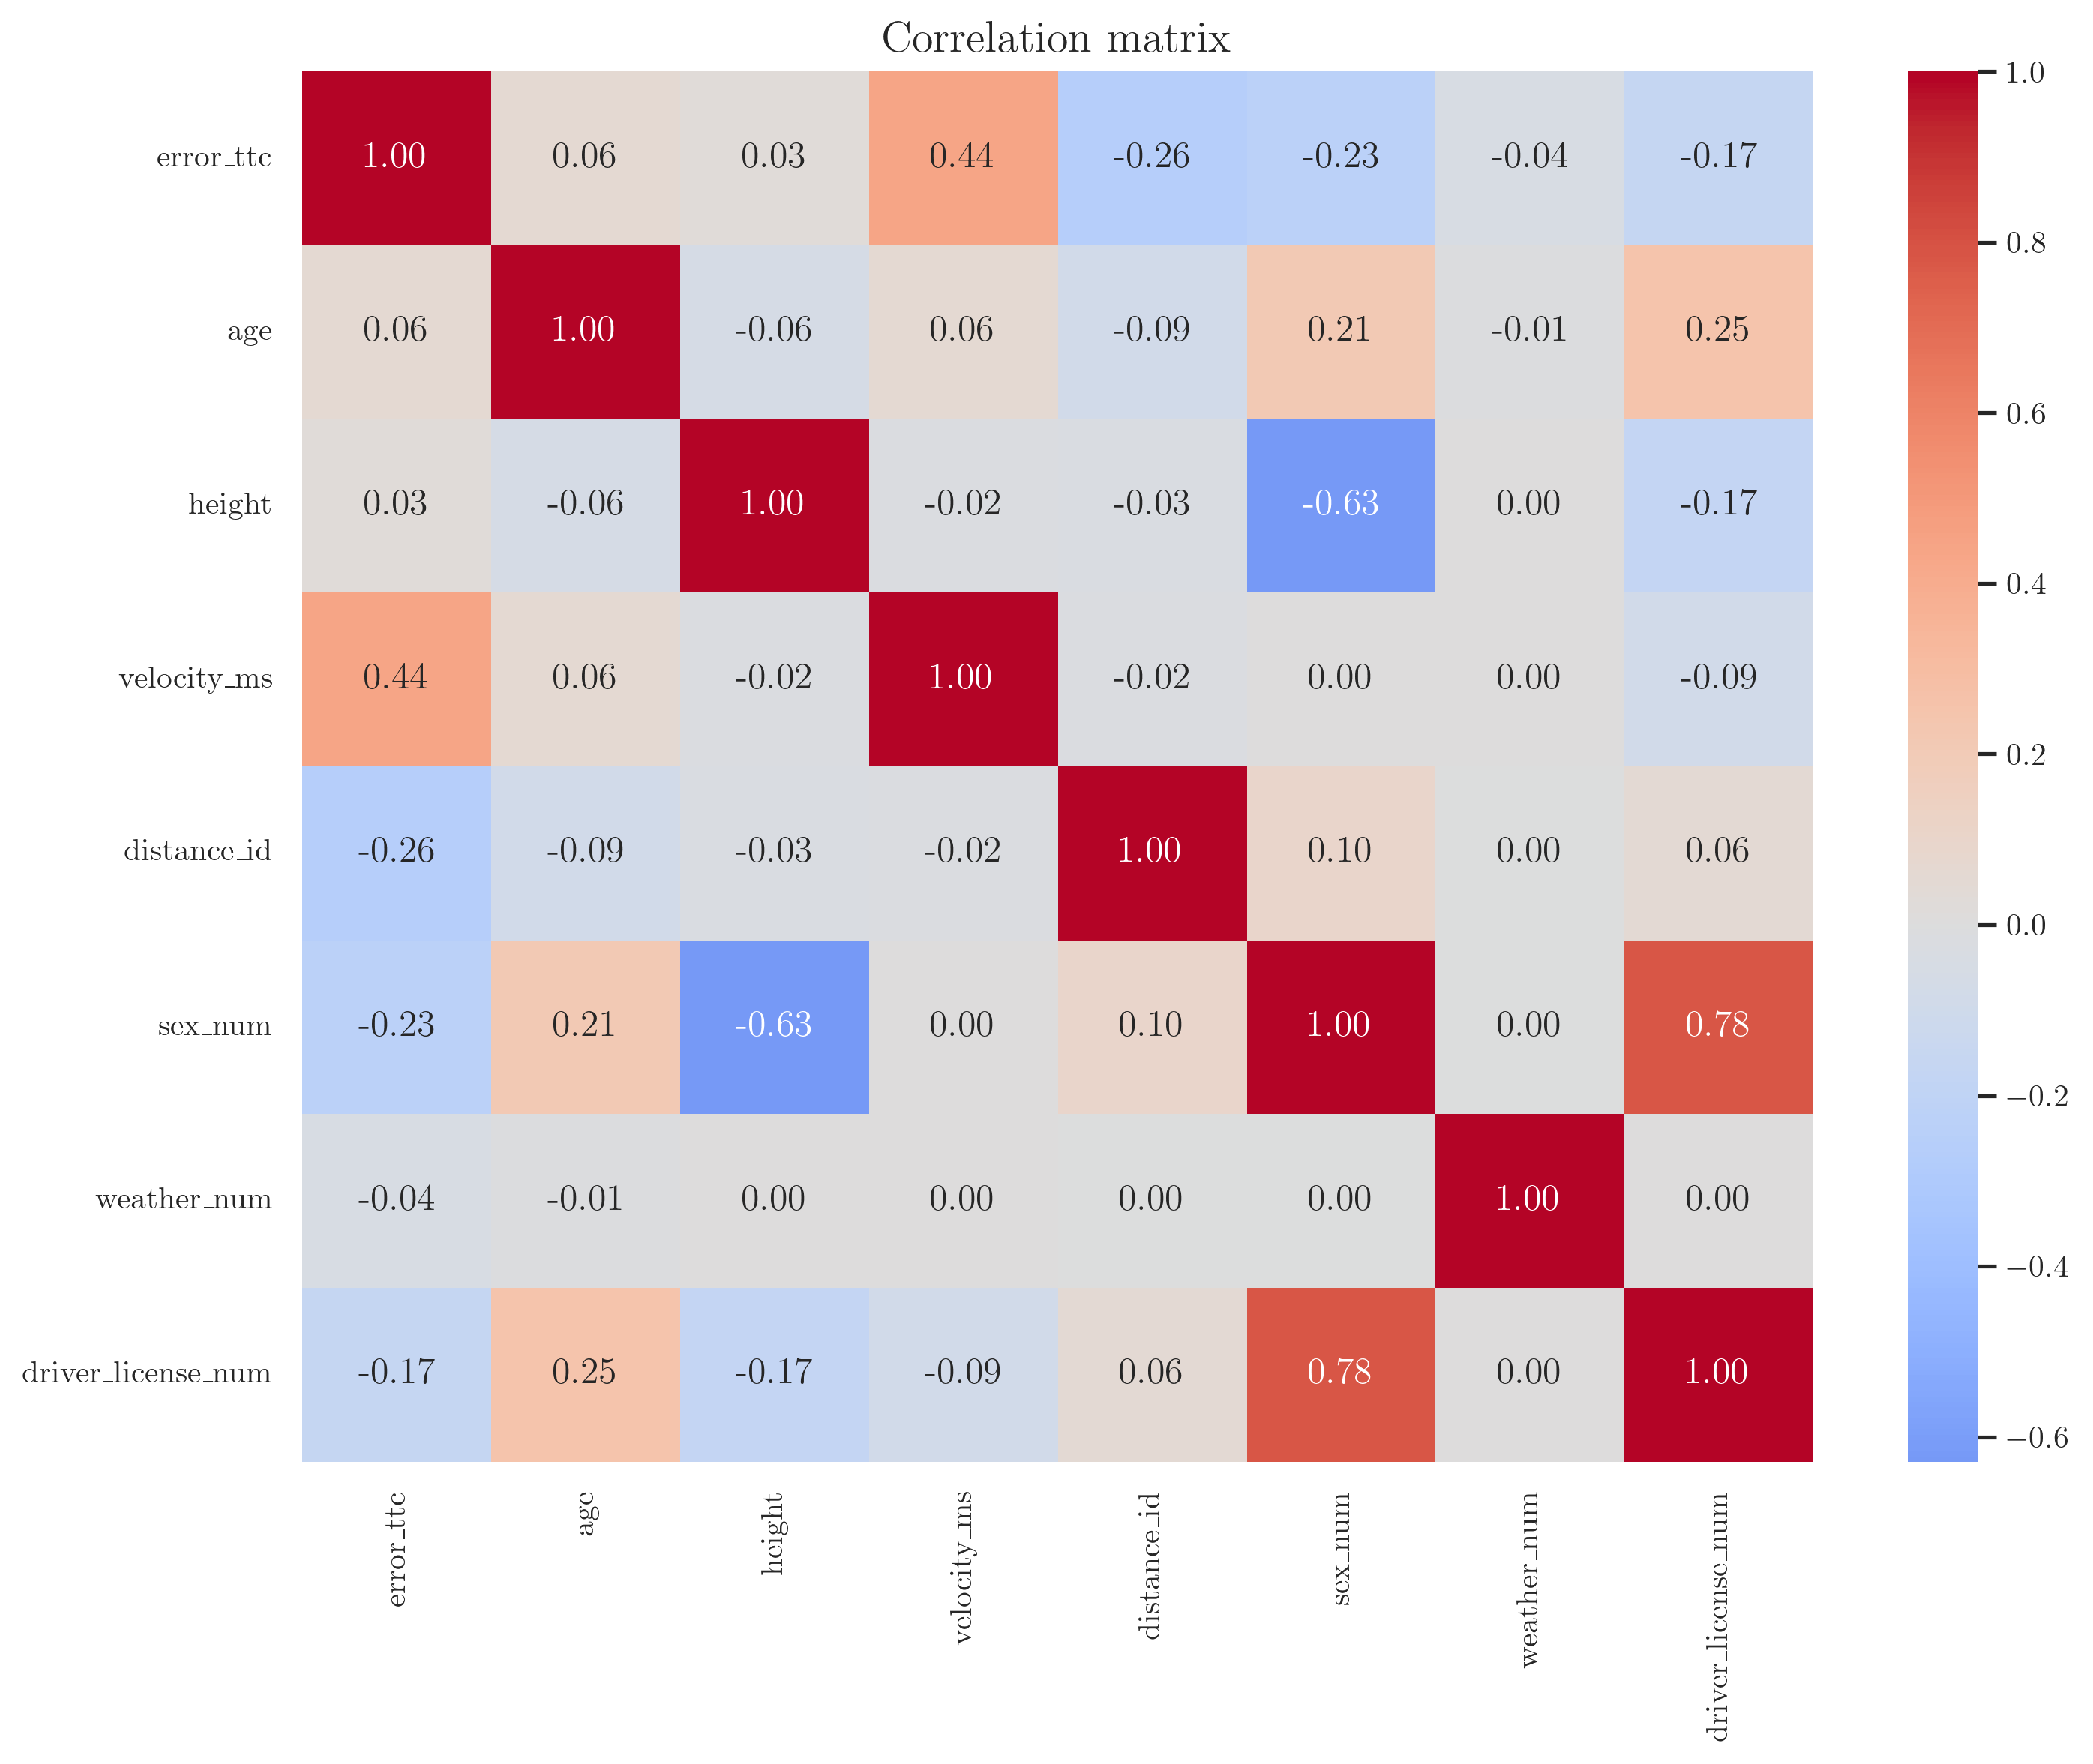

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copier df_merged pour ne pas modifier l'original
df_corr = df_merged.copy()

# Encodage simple des variables catégorielles
df_corr['sex_num'] = df_corr['sex'].astype('category').cat.codes
df_corr['weather_num'] = df_corr['weather_id'].astype('category').cat.codes
df_corr['driver_license_num'] = df_corr['driver_license'].astype('category').cat.codes

# Colonnes numériques + colonnes encodées
cols_corr = ['error_ttc', 'age', 'height', 'velocity_ms', 'distance_id', 'sex_num', 'weather_num', 'driver_license_num']

# Calcul matrice de corrélation Pearson
corr_matrix = df_corr[cols_corr].corr()

# Affichage heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation matrix")
plt.show()


##  Tests statistiques multigroupes (ANOVA vs Kruskal–Wallis) + Post-hoc

Dans cette section, nous évaluons si l’erreur TTC (`error_ttc`) varie de manière significative **en fonction des caractéristiques individuelles** des participants :

- `age`
- `height`
- `sex`
- `driver_license`

L’objectif est d’identifier si certains profils présentent systématiquement des performances d’estimation du TTC meilleures ou moins bonnes.

###  1. Vérification des conditions d’application (normalité + homogénéité)

Pour chaque variable, la fonction `check_assumptions()` :

- effectue un **test de normalité** (Shapiro–Wilk) dans chaque groupe ;
- teste l’**homogénéité des variances** (test de Levene) entre groupes.

Ces deux conditions déterminent quel test doit être utilisé pour comparer les groupes.

###  2. Sélection automatique du bon test

Selon les résultats :

####  Si toutes les conditions sont respectées :
→ **ANOVA à un facteur (f_oneway)**  
Modèle paramétrique adapté aux comparaisons de moyennes.

Si ANOVA est significative (p < 0.05), un test post-hoc :
→ **Tukey HSD**  
permet d’identifier précisément quels groupes diffèrent.

####  Si au moins une condition n’est pas respectée :
→ **Kruskal–Wallis**  
Test non paramétrique basé sur les rangs.

Si Kruskal–Wallis est significatif, le post-hoc utilisé est :
→ **Dunn (correction Bonferroni)**.

###  3. Variables analysées

La boucle finale applique la procédure à chaque variable participante :

- `age` (continu → analysé tel quel)
- `height`
- `sex` (catégorie binaire)
- `driver_license` (binaire)

###  Intérêt de cette analyse

Elle permet de vérifier si les différences individuelles influencent :

- la capacité à estimer un TTC court,
- le biais perceptif général,
- le niveau d’incertitude.

Les tests post-hoc permettent d’identifier **quels groupes spécifiques** ont des différences significatives, par exemple :

- un groupe d’âge extrême affichant plus d’erreurs,  
- ou une différence entre conducteurs et non-conducteurs.

Même en cas de non-significativité globale, cette approche valide statistiquement
que **les facteurs individuels n’expliquent pas la variabilité des erreurs TTC**, ce qui est un résultat important en soi pour ta thèse.



In [23]:
import numpy as np
from scipy.stats import f_oneway, kruskal, levene, shapiro
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

# Fonction pour tester normalité + homogénéité des variances
def check_assumptions(df, group_col, value_col='error_ttc'):
    groups = [df[df[group_col] == lvl][value_col].dropna() for lvl in df[group_col].unique()]
    
    # Test de normalité par groupe (Shapiro)
    normal = all(shapiro(g)[1] > 0.05 for g in groups if len(g) >= 3)  # attention taille >=3
    
    # Test d'homogénéité (Levene)
    homo = levene(*groups)[1] > 0.05
    
    return normal, homo

# Fonction test et post-hoc
def test_groups(df, group_col, value_col='error_ttc'):
    print(f"\n*** Analysis for {group_col} ***")
    normal, homo = check_assumptions(df, group_col, value_col)
    print(f"Normality: {normal}, Homogeneity: {homo}")

    groups = [df[df[group_col] == lvl][value_col].dropna() for lvl in df[group_col].unique()]
    
    if normal and homo:
        print("Using ANOVA")
        stat, p = f_oneway(*groups)
        print(f"ANOVA: stat={stat:.4f}, p={p:.4e}")
        if p < 0.05:
            # Post-hoc Tukey HSD
            tukey = pairwise_tukeyhsd(df[value_col], df[group_col])
            print(tukey.summary())
    else:
        print("Using Kruskal-Wallis")
        stat, p = kruskal(*groups)
        print(f"Kruskal-Wallis: stat={stat:.4f}, p={p:.4e}")
        if p < 0.05:
            # Post-hoc Dunn avec correction Bonferroni
            dunn = sp.posthoc_dunn(df, val_col=value_col, group_col=group_col, p_adjust='bonferroni')
            print("Post-hoc Dunn test (p-values):")
            print(dunn)

# Liste des variables participants à tester
participant_vars = ['age', 'height', 'sex', 'driver_license']

for var in participant_vars:
    test_groups(df_merged, var)



*** Analysis for age ***
Normality: False, Homogeneity: False
Using Kruskal-Wallis
Kruskal-Wallis: stat=nan, p=nan

*** Analysis for height ***
Normality: False, Homogeneity: False
Using Kruskal-Wallis
Kruskal-Wallis: stat=nan, p=nan

*** Analysis for sex ***
Normality: False, Homogeneity: False
Using Kruskal-Wallis
Kruskal-Wallis: stat=nan, p=nan

*** Analysis for driver_license ***
Normality: False, Homogeneity: False
Using Kruskal-Wallis
Kruskal-Wallis: stat=nan, p=nan


C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\4075513037.py:14: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  homo = levene(*groups)[1] > 0.05
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\4075513037.py:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = kruskal(*groups)


##  Test statistique : Différences d’erreur TTC entre hommes et femmes

Dans cette section, nous évaluons si l’erreur d’estimation du TTC (**TTC Error**) diffère de manière significative entre les deux catégories de sexe :

- **Man**
- **Woman**

###  Objectif
Déterminer si le sexe des participants influence leur capacité à estimer le Time-To-Collision.

###  Méthodologie

1. **Séparation des données**
   - `group_male` : erreurs TTC des participants identifiés comme *Man*
   - `group_female` : erreurs TTC des participants identifiés comme *Woman*

2. **Test de normalité**
   Pour chaque groupe, un test **Shapiro–Wilk** est appliqué :
   - Si **normalité respectée dans les deux groupes** → test paramétrique
   - Sinon → test non paramétrique

3. **Choix du test statistique**
   -  **T-test indépendant (Student)** si les deux groupes suivent une distribution normale  
     → compare les moyennes des deux groupes
   -  **Mann–Whitney U test** sinon  
     → compare les distributions sans hypothèse de normalité

###  Interprétation des résultats

- Si *p < 0.05* → différence significative entre hommes et femmes.
- Si *p ≥ 0.05* → aucune différence statistiquement significative observée.

Ce test est important pour vérifier si l’effet du **sexe** intervient dans la perception du TTC ou si la variabilité est dominée par d’autres facteurs (vitesse, distance, météo, différences individuelles aléatoires…).



In [24]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

group_male = df_merged[df_merged['sex'] == 'Man']['error_ttc']
group_female = df_merged[df_merged['sex'] == 'Woman']['error_ttc']

_, p_male = shapiro(group_male)
_, p_female = shapiro(group_female)

if p_male > 0.05 and p_female > 0.05:
    stat, p = ttest_ind(group_male, group_female)
    print(f"T-test (normality ok): stat={stat:.3f}, p={p:.3f}")
else:
    stat, p = mannwhitneyu(group_male, group_female)
    print(f"Mann-Whitney (normality violated): stat={stat:.3f}, p={p:.3f}")


Mann-Whitney (normality violated): stat=27250.000, p=0.000


##  Corrélations entre l’erreur TTC, l’âge et la taille

L’objectif de cette section est d’évaluer si deux caractéristiques individuelles  **l’âge** et la **taille** des participants  sont associées à leur capacité d’estimation du Time-To-Collision (TTC).

###  Objectif
Déterminer si les participants plus âgés ou plus grands présentent :
- des erreurs TTC plus élevées,
- une sous- ou surestimation systématique,
- ou aucune relation significative.

###  Préparation des données
Avant de calculer les corrélations, les valeurs aberrantes sont contrôlées :
- Les valeurs `inf` et `-inf` sont remplacées par `NaN`.
- Les lignes sans âge, taille ou erreur TTC sont supprimées pour éviter des biais.

###  Méthode statistique : corrélation de Pearson
La corrélation de Pearson est utilisée car :
- `age`, `height` et `error_ttc` sont des variables continues,
- elle permet de quantifier une relation **linéaire** entre deux mesures.

Pour chaque variable (`age`, `height`) :
1. On calcule le coefficient de corrélation `r`.
2. On teste sa significativité via une p-value.

###  Interprétation
- **r positif** → plus la variable augmente, plus l’erreur TTC augmente  
  (ex. sujets plus âgés = estimation moins précise)
- **r négatif** → plus la variable augmente, plus l’erreur TTC diminue  
  (ex. participants plus grands = meilleure estimation)
- **p < 0.05** → relation statistiquement significative
- **p ≥ 0.05** → absence d'association linéaire significative

Ce test permet de déterminer si l’erreur d’estimation du TTC est influencée par des caractéristiques individuelles simples ou si elle reste indépendante de ces facteurs.



In [25]:
# Supprimer les lignes avec valeurs infinies dans age, height, ou error_ttc
df_clean = df_merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['age', 'height', 'error_ttc'])

from scipy.stats import pearsonr

for var in ['age', 'height']:
    corr, pval = pearsonr(df_clean[var], df_clean['error_ttc'])
    print(f"Pearson correlation between TTC Error and {var}: r = {corr:.3f}, p = {pval:.3f}")


Pearson correlation between TTC Error and age: r = 0.063, p = 0.192
Pearson correlation between TTC Error and height: r = 0.029, p = 0.544


##  Scatterplots : TTC Error en fonction de l’âge et de la taille

Cette section visualise la relation entre l’erreur d’estimation du TTC (`error_ttc`) et deux caractéristiques individuelles :
- **l’âge** des participants,
- **leur taille**.

###  Objectif
Compléter les tests de corrélation précédents par une **visualisation intuitive**, permettant :
- de vérifier la forme de la relation (linéaire ou non),
- d’observer la dispersion des erreurs selon l’âge et la taille,
- de repérer visuellement d’éventuels groupes ou outliers.

###  Méthode utilisée
Chaque graphique combine :
- un **nuage de points** (`regplot`) représentant les observations individuelles,
- une **droite de régression linéaire** estimant la tendance générale,
- un fond quadrillé pour faciliter la lecture.

###  Interprétation
- Une **pente positive** indiquerait que l’erreur TTC **augmente** avec l’âge ou la taille.
- Une **pente négative** indiquerait une **meilleure précision** lorsque la variable augmente.
- Une **pente quasi nulle** confirme l’absence de relation linéaire significative (ce que les tests statistiques suggèrent également dans ce jeu de données).

Ces visualisations permettent de confirmer que les éventuelles corrélations observées ne résultent pas d’un comportement non linéaire ou d’un sous-groupe atypique invisible dans les tests statistiques bruts.


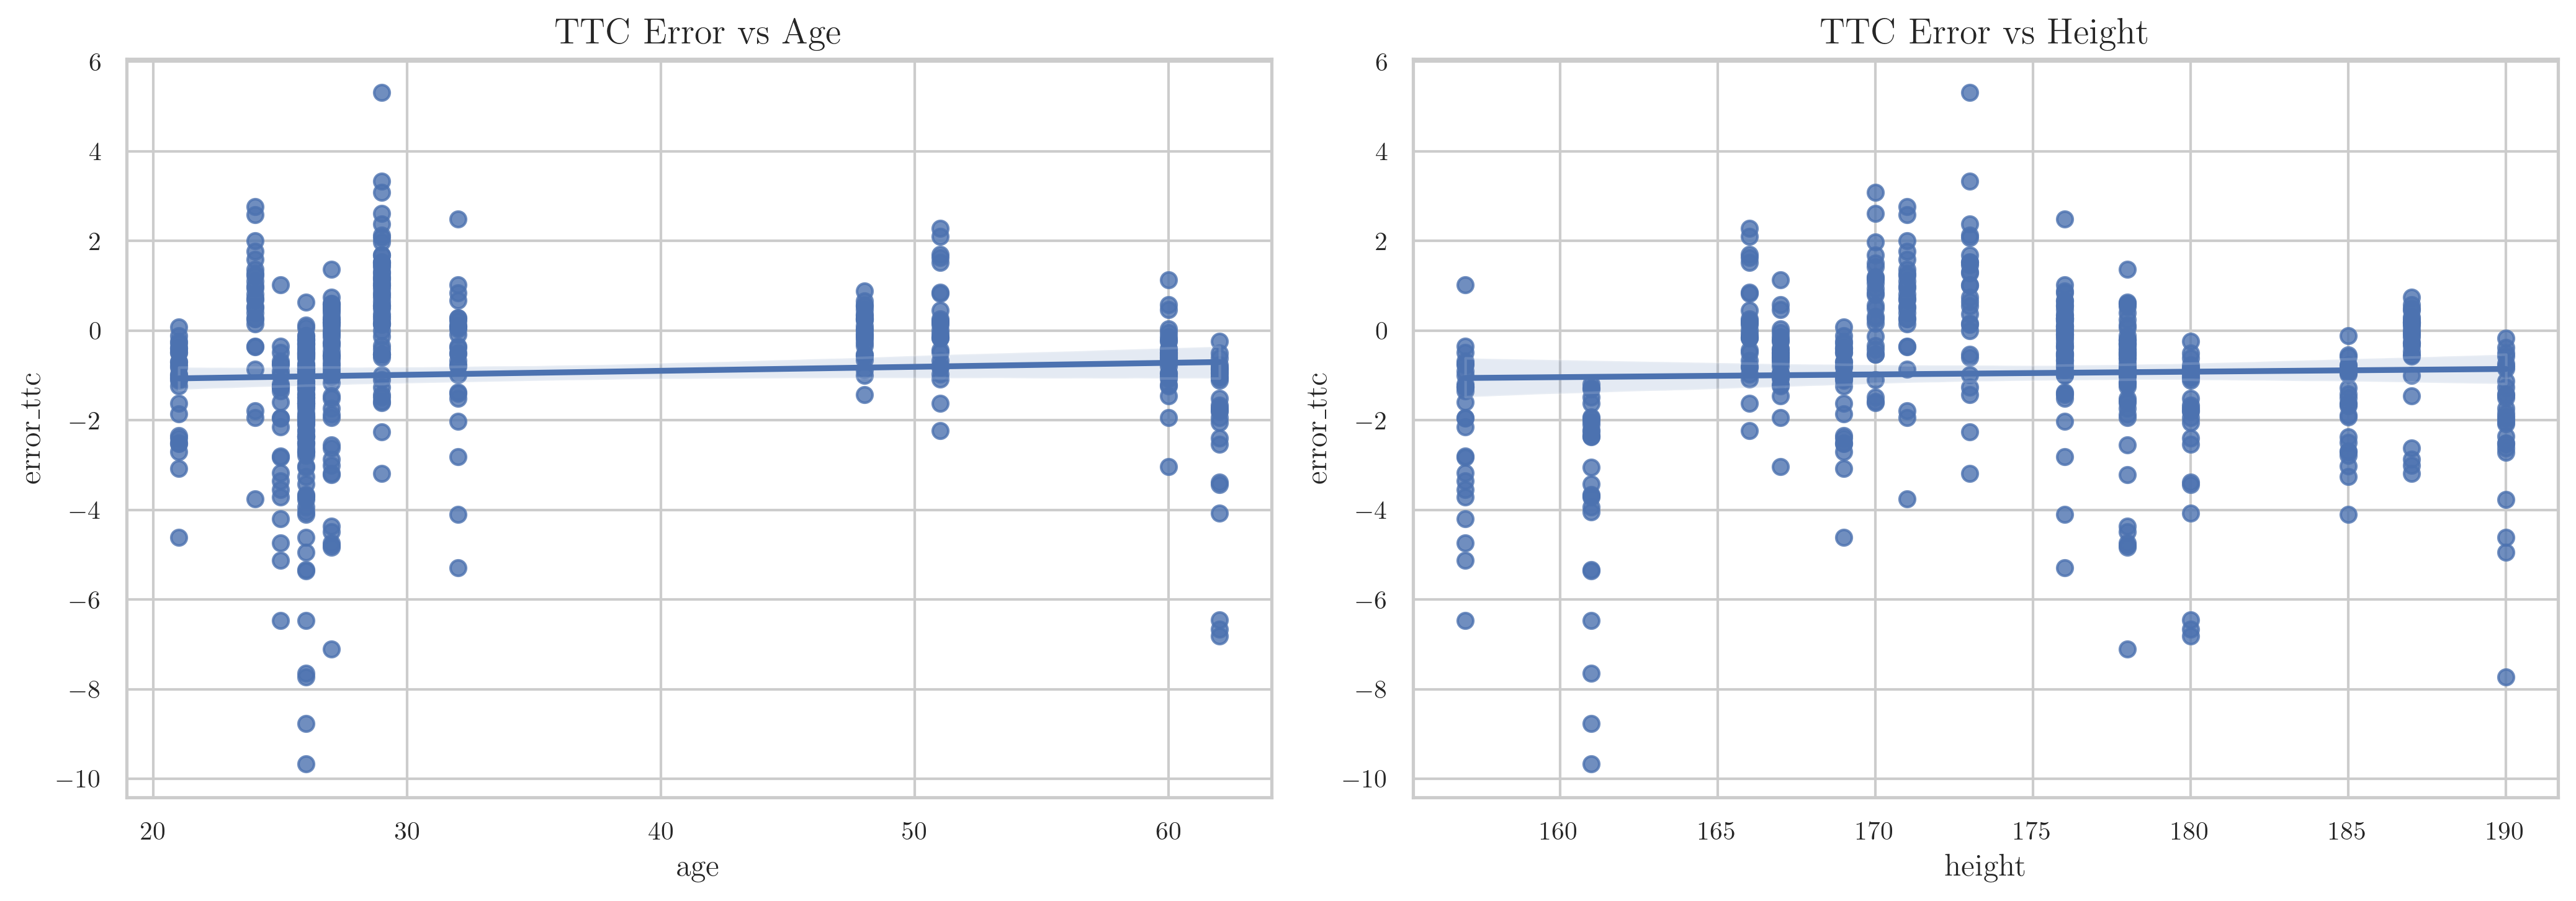

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.regplot(x='age', y='error_ttc', data=df_merged, ax=axes[0])
axes[0].set_title('TTC Error vs Age')
axes[0].grid(True)

sns.regplot(x='height', y='error_ttc', data=df_merged, ax=axes[1])
axes[1].set_title('TTC Error vs Height')
axes[1].grid(True)

plt.tight_layout()
plt.show()


##  Boxplot & Test statistique — Effet du permis de conduire sur l’erreur TTC

Cette section analyse si la possession du **permis de conduire** influence la précision d’estimation du TTC.

###  Objectif
Comparer les erreurs d’estimation (`error_ttc`) entre deux groupes :
- **Participants avec permis** (`driver_license = 1`)
- **Participants sans permis** (`driver_license = 0`)

###  Méthodologie
1. **Séparation** des deux groupes sur la base de `driver_license`.
2. **Test de normalité** (Shapiro-Wilk) dans chaque groupe.
3. Choix du test statistique :
   - Si les deux groupes suivent une distribution normale → **T-test indépendant**
   - Sinon → **Test de Mann–Whitney U** (non paramétrique)

###  Interprétation du résultat
- Un **p-value < 0.05** indique une différence significative entre les deux groupes → la possession du permis aurait un impact sur la précision TTC.
- Un **p-value ≥ 0.05** suggère qu’il n’y a **pas de différence statistique** notable — c’est généralement ce qu’on observe dans ce type de tâche perceptive.

Le boxplot (dans la cellule précédente) permet également de visualiser :
- la médiane,
- la dispersion,
- la présence potentielle d’outliers,
offrant un complément visuel au test statistique.


In [27]:
group_yes = df_merged[df_merged['driver_license'] == 1]['error_ttc']
group_no = df_merged[df_merged['driver_license'] == 0]['error_ttc']

_, p_yes = shapiro(group_yes)
_, p_no = shapiro(group_no)

if p_yes > 0.05 and p_no > 0.05:
    stat, p = ttest_ind(group_yes, group_no)
    print(f"T-test (normality ok): stat={stat:.3f}, p={p:.3f}")
else:
    stat, p = mannwhitneyu(group_yes, group_no)
    print(f"Mann-Whitney (normality violated): stat={stat:.3f}, p={p:.3f}")


Mann-Whitney (normality violated): stat=9140.000, p=0.316



##  Analyse post-hoc sur l’âge et la taille (Kruskal–Wallis + Dunn)

Les variables **âge** et **taille** des participants ont été discrétisées en groupes (quartiles pour l’âge, quintiles pour la taille) afin d’examiner si l’erreur d’estimation du TTC diffère significativement entre catégories.

Étant donné que :
- les distributions d’erreurs **ne sont pas normales**,
- les tailles de groupes sont modestes et inégales,
- l’homogénéité des variances n’est pas garantie,

➡️ Nous utilisons un **test non paramétrique de Kruskal–Wallis**, suivi d’un **post-hoc Dunn** (avec correction de Bonferroni) pour identifier **quelles paires de groupes** diffèrent significativement.


###  Structure générale de la cellule

La cellule ci-dessous comprend 3 étapes :


### **1. Fonctions utilitaires**  
Pour garantir une analyse propre et robuste :

- `_levels_in_order`  
  Assure que l’ordre des catégories (Q1, Q2…) est cohérent et lisible.

- `_fmt_p`  
  Formate joliment les valeurs p en LaTeX, avec **mise en gras** si `p < 0.01`.

- `_latex_upper_triangle`  
  Construit un **tableau LaTeX triangulaire supérieur** où :
  - chaque cellule contient une p-value Dunn
  - la diagonale = “---”
  - seule la partie supérieure est affichée (évite la symétrie redondante)

- `_kruskal_dunn_clean`  
  Pipeline complet :
  - nettoyage des NaN/infs  
  - réordonnancement cohérent des groupes  
  - Kruskal–Wallis global  
  - Dunn post-hoc (Bonferroni)  
  - construction d’une matrice de p-values propre et ordonnée  


### **2. Application aux catégories d’âge et de taille**  

Pour l’âge :

\[
H = H_{\text{age}}, \quad p = p_{\text{age}}
\]

Pour la taille :

\[
H = H_{\text{height}}, \quad p = p_{\text{height}}
\]

Chaque analyse produit :

- **une matrice de p-values post-hoc** (test de Dunn)  
- **un tableau LaTeX prêt à coller dans la thèse**  
  avec p-values formatées, et valeurs significatives en **gras**



### **3. Génération des tableaux LaTeX**

Les commandes :

```python
print(latex_age)
print(latex_h)
```

affichent directement deux tableaux LaTeX :

* **Tableau A. Post-hoc Dunn sur les catégories d’âge**
* **Tableau B. Post-hoc Dunn sur les catégories de taille**


###  **Interprétation des tableaux Dunn**

Pour chaque paire de groupes (ex. *Groupe 1* vs *Groupe 3*) :

* une **p-value faible (< 0.01)** → différence significative d’erreur TTC entre les groupes
* une **p-value élevée** → pas de différence statistique détectée

Cela permet d’identifier **quels profils de participants** influencent réellement la perception du TTC.


In [30]:
import numpy as np
import pandas as pd
from scipy import stats
import scikit_posthocs as sp

# ================== Helpers robustes ==================
def _levels_in_order(s: pd.Series):
    """Ordre lisible: catégories si dispo (sans catégories non utilisées), sinon ordre d'apparition."""
    if pd.api.types.is_categorical_dtype(s):
        s = s.cat.remove_unused_categories()
        return list(s.cat.categories)
    return list(pd.unique(s.dropna()))

def _fmt_p(p: float) -> str:
    if p < 1e-4:
        s = "0.0001"
    else:
        s = f"{p:.3g}"
    return f"\\textbf{{{s}}}" if p < 0.01 else s

def _latex_upper_triangle(pmat: pd.DataFrame, title: str, label: str) -> str:
    groups = list(pmat.index)
    n = len(groups)
    header = " & " + " & ".join(groups) + " \\\\"
    lines = [
        "\\begin{table*}[ht]",
        "\\centering",
        f"\\caption{{{title}}}",
        f"\\label{{{label}}}",
        f"\\begin{{tabular}}{{l{'c'*n}}}",
        "\\toprule",
        header,
        "\\midrule",
    ]
    for i in range(n):
        row = [groups[i]]
        for j in range(n):
            if j < i:
                row.append("")
            elif j == i:
                row.append("---")
            else:
                row.append(_fmt_p(float(pmat.iloc[i, j])))
        lines.append(" & ".join(row) + " \\\\")
    lines += ["\\bottomrule", "\\end{tabular}", "\\end{table*}"]
    return "\n".join(lines)

def _kruskal_dunn_clean(df, value_col, group_col):
    """Kruskal + Dunn (Bonferroni) robuste aux NaN et catégories -1."""
    # 1) Sous-ensemble propre (pas de NaN ni infs)
    tmp = df[[value_col, group_col]].copy()
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna(subset=[value_col, group_col])

    # 2) Si catégorielle, retirer catégories inutilisées
    if pd.api.types.is_categorical_dtype(tmp[group_col]):
        tmp[group_col] = tmp[group_col].cat.remove_unused_categories()

    # 3) Forcer des étiquettes sûres (str) sans 'nan'
    #    (on conserve l'ordre humain capturé avant conversion)
    levels = _levels_in_order(tmp[group_col])
    tmp["_grp_str"] = pd.Categorical(tmp[group_col], categories=levels, ordered=True).astype(str)

    # 4) Kruskal–Wallis (dans l'ordre des niveaux)
    groups_data = [tmp.loc[tmp["_grp_str"] == lvl, value_col].values for lvl in map(str, levels)]
    H, p_kw = stats.kruskal(*groups_data)

    # 5) Dunn avec Bonferroni sur la colonne string propre
    pmat = sp.posthoc_dunn(tmp, val_col=value_col, group_col="_grp_str", p_adjust="bonferroni")

    # 6) Réindexer au bon ordre + diagonale NaN
    pmat = pmat.loc[list(map(str, levels)), list(map(str, levels))].astype(float)
    np.fill_diagonal(pmat.values, np.nan)
    return H, p_kw, pmat, list(map(str, levels))

# ================== Paramètres ==================
VALUE = "error_ttc"
AGE_COL = "age_cat"       # 4 groupes (Q1..Q4)
HEIGHT_COL = "height_cat" # 5 groupes (Q1..Q5)

# ================== Analyses ==================
# AGE
H_age, p_age, pmat_age, age_levels = _kruskal_dunn_clean(df_merged, VALUE, AGE_COL)
caption_age = (
    "Post hoc pairwise comparisons (Dunn's test, Bonferroni-corrected $p$-values) "
    f"for Age groups on TTC Estimation Error. Kruskal--Wallis: $H={H_age:.3f}$, $p={p_age:.3g}$. "
    "Significant comparisons ($p < 0.01$) are in bold."
)
label_age = "tab:posthoc_age_ttc"
latex_age = _latex_upper_triangle(pmat_age, caption_age, label_age)

# HEIGHT
H_h, p_h, pmat_h, height_levels = _kruskal_dunn_clean(df_merged, VALUE, HEIGHT_COL)
caption_h = (
    "Post hoc pairwise comparisons (Dunn's test, Bonferroni-corrected $p$-values) "
    f"for Height groups on TTC Estimation Error. Kruskal--Wallis: $H={H_h:.3f}$, $p={p_h:.3g}$. "
    "Significant comparisons ($p < 0.01$) are in bold."
)
label_h = "tab:posthoc_height_ttc"
latex_h = _latex_upper_triangle(pmat_h, caption_h, label_h)

# ================== Affichage demandé: juste les tableaux ==================
print(latex_age)
print()
print(latex_h)


\begin{table*}[ht]
\centering
\caption{Post hoc pairwise comparisons (Dunn's test, Bonferroni-corrected $p$-values) for Age groups on TTC Estimation Error. Kruskal--Wallis: $H=65.204$, $p=4.54e-14$. Significant comparisons ($p < 0.01$) are in bold.}
\label{tab:posthoc_age_ttc}
\begin{tabular}{lcccc}
\toprule
 & Group 1 & Group 2 & Group 3 & Group 4 \\
\midrule
Group 1 & --- & 0.101 & \textbf{0.0001} & \textbf{0.0001} \\
Group 2 &  & --- & \textbf{0.000778} & 1 \\
Group 3 &  &  & --- & \textbf{0.00374} \\
Group 4 &  &  &  & --- \\
\bottomrule
\end{tabular}
\end{table*}

\begin{table*}[ht]
\centering
\caption{Post hoc pairwise comparisons (Dunn's test, Bonferroni-corrected $p$-values) for Height groups on TTC Estimation Error. Kruskal--Wallis: $H=74.205$, $p=2.94e-15$. Significant comparisons ($p < 0.01$) are in bold.}
\label{tab:posthoc_height_ttc}
\begin{tabular}{lccccc}
\toprule
 & Group 1 & Group 2 & Group 3 & Group 4 & Group 5 \\
\midrule
Group 1 & --- & \textbf{0.0001} & \textbf{0.

C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3015398007.py:55: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(tmp[group_col]):
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3015398007.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3015398007.py:55: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(tmp[group_col]):
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3015398007.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.Categ

##  Analyse complémentaire : matrices Dunn (non-corrigées et corrigées) pour l’âge et la taille

La cellule suivante offre une version **complète et transparente** de l’analyse post-hoc réalisée sur les groupes d’âge et de taille.  
Contrairement aux tableaux LaTeX produits plus haut, cette cellule affiche **toutes les variantes possibles** de correction des p-values du test de Dunn :

- **Sans correction** (raw)
- **Correction de Holm** (step-down)
- **Correction FDR Benjamini–Hochberg**
- **Correction de Bonferroni** (plus stricte)

 *Objectif : permettre une lecture exhaustive et reproductible des comparaisons multiples entre groupes.*



###  Structure du code

La cellule est organisée en 3 parties :


### **1. Fonctions utilitaires pour un post-hoc propre**

Elle définit :

####  `_natural_key`  
Permet un tri “naturel” des catégories (utile pour des labels comme `Group 1`, `Group 2`, etc.).

####  `_prepare_for_posthoc()`  
Pipeline de préparation pour le test de Dunn :
- suppression des NaN et valeurs infinies  
- nettoyage des catégories inutilisées  
- normalisation propre des labels  
- tri cohérent des groupes  
- création d’une colonne unique `grp`

Cette fonction garantit **des matrices de p-values propres, ordonnées et alignées**.

####  `dunn_matrix()`  
Exécute directement :
- le test de Dunn (`scikit_posthocs`)
- applique la correction souhaitée (`raw`, `holm`, `fdr_bh`, `bonferroni`)
- reconstruit une matrice carrée alignée sur l’ordre des groupes



### **2. Application aux groupes d’âge**

Quatre matrices sont produites :

- `pmat_raw_age` : p-values brutes  
- `pmat_holm_age` : Holm (moins sévère que Bonferroni)  
- `pmat_fdr_age` : contrôle du taux de faux positifs  
- `pmat_bonf_age` : Bonferroni (la plus conservatrice)

Ces matrices permettent d’évaluer la **robustesse** des différences entre groupes d’âge.



### **3. Application aux groupes de taille**

Même analyse que pour l’âge, mais cette fois sur les **5 quintiles de taille**.



###  Intérêt de cette cellule

Cette étape finale permet :

- de vérifier si des résultats significatifs persistent selon différentes corrections  
- d’éviter un faux-positif dû à une correction trop laxiste  
- de mieux comprendre si les groupes diffèrent réellement ou si les résultats sont sensibles à la méthode utilisée  
- de garantir une **transparence totale** dans ton analyse statistique (important pour une thèse !)



###  Interprétation

Pour chaque matrice :

- une **p-value faible (< 0.05)** signale une différence statistique entre deux groupes  
- la comparaison des versions (raw, Holm, FDR, Bonferroni) informe sur :
  - la solidité du résultat  
  - sa sensibilité à la correction du risque de faux positifs  

Si une différence reste significative **après Bonferroni**, elle est particulièrement robuste.



###  Output

La cellule affiche successivement :

- l’ordre des niveaux (`Group 1`, `Group 2`…)  
- les 4 matrices de p-values pour l’âge  
- les 4 matrices de p-values pour la taille  

Toutes directement lisibles dans le notebook.



In [32]:
import numpy as np
import pandas as pd
import re
import scikit_posthocs as sp

def _natural_key(s: str):
    return [int(t) if t.isdigit() else t for t in re.split(r'(\d+)', s)]

def _prepare_for_posthoc(df, value_col, group_col):
    """Retourne df_tmp (nettoyé), levels (ordre), et le nom de la colonne groupe propre 'grp'."""
    tmp = df[[value_col, group_col]].copy()
    # drop NaN et inf
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna(subset=[value_col, group_col])

    s = tmp[group_col]
    # enlever catégories non utilisées si c'est catégoriel
    if pd.api.types.is_categorical_dtype(s):
        s = s.cat.remove_unused_categories()

    # ordre des niveaux: si catégoriel -> catégories; sinon -> tri naturel des libellés
    if pd.api.types.is_categorical_dtype(s):
        levels = list(s.cat.categories)
    else:
        levels = list(pd.unique(s))

    # convertir en chaînes sûres
    tmp["grp"] = pd.Categorical(s, categories=levels, ordered=True).astype(str)

    # si les libellés ressemblent à Q1, Q2... on les trie naturellement
    levels_str = list(pd.unique(tmp["grp"]))
    try:
        levels_str_sorted = sorted(levels_str, key=_natural_key)
    except Exception:
        levels_str_sorted = levels_str

    # refixer l'ordre
    tmp["grp"] = pd.Categorical(tmp["grp"], categories=levels_str_sorted, ordered=True)
    return tmp, levels_str_sorted, "grp"

def dunn_matrix(df, value_col, group_col, p_adjust=None):
    tmp, levels, grp_col = _prepare_for_posthoc(df, value_col, group_col)
    pmat = sp.posthoc_dunn(tmp, val_col=value_col, group_col=grp_col, p_adjust=p_adjust)
    # réindex proprement + float
    pmat = pmat.loc[levels, levels].astype(float)
    return pmat, levels

# ================== Âge ==================
pmat_raw_age, age_levels = dunn_matrix(df_merged, "error_ttc", "age_cat", p_adjust=None)
pmat_holm_age, _        = dunn_matrix(df_merged, "error_ttc", "age_cat", p_adjust="holm")
pmat_fdr_age, _         = dunn_matrix(df_merged, "error_ttc", "age_cat", p_adjust="fdr_bh")
pmat_bonf_age, _        = dunn_matrix(df_merged, "error_ttc", "age_cat", p_adjust="bonferroni")

print("Age levels:", age_levels)
print("\nDunn raw p-values (Age):\n", pmat_raw_age)
print("\nDunn Holm (Age):\n", pmat_holm_age)
print("\nDunn FDR BH (Age):\n", pmat_fdr_age)
print("\nDunn Bonferroni (Age):\n", pmat_bonf_age)

# ================== Taille ==================
pmat_raw_h, height_levels = dunn_matrix(df_merged, "error_ttc", "height_cat", p_adjust=None)
pmat_holm_h, _            = dunn_matrix(df_merged, "error_ttc", "height_cat", p_adjust="holm")
pmat_fdr_h, _             = dunn_matrix(df_merged, "error_ttc", "height_cat", p_adjust="fdr_bh")
pmat_bonf_h, _            = dunn_matrix(df_merged, "error_ttc", "height_cat", p_adjust="bonferroni")

print("\nHeight levels:", height_levels)
print("\nDunn raw p-values (Height):\n", pmat_raw_h)
print("\nDunn Holm (Height):\n", pmat_holm_h)
print("\nDunn FDR BH (Height):\n", pmat_fdr_h)
print("\nDunn Bonferroni (Height):\n", pmat_bonf_h)


Age levels: ['Group 1', 'Group 2', 'Group 3', 'Group 4']

Dunn raw p-values (Age):
               Group 1   Group 2       Group 3   Group 4
Group 1  1.000000e+00  0.016897  4.732883e-15  0.000009
Group 2  1.689721e-02  1.000000  1.296814e-04  0.312988
Group 3  4.732883e-15  0.000130  1.000000e+00  0.000623
Group 4  9.140843e-06  0.312988  6.227144e-04  1.000000

Dunn Holm (Age):
               Group 1   Group 2       Group 3   Group 4
Group 1  1.000000e+00  0.033794  2.839730e-14  0.000046
Group 2  3.379442e-02  1.000000  5.187256e-04  0.312988
Group 3  2.839730e-14  0.000519  1.000000e+00  0.001868
Group 4  4.570422e-05  0.312988  1.868143e-03  1.000000

Dunn FDR BH (Age):
               Group 1   Group 2       Group 3   Group 4
Group 1  1.000000e+00  0.020277  2.839730e-14  0.000027
Group 2  2.027665e-02  1.000000  2.593628e-04  0.312988
Group 3  2.839730e-14  0.000259  1.000000e+00  0.000934
Group 4  2.742253e-05  0.312988  9.340716e-04  1.000000

Dunn Bonferroni (Age):
            

C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3286302088.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3286302088.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3286302088.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
C:\Users\svictor\AppData\Local\Temp\ipykernel_29648\3286302088.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  i